In [1]:
import glob

In [469]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors as mcolors
from matplotlib import patches
import numpy as np
import pandas as pd
import seaborn.apionly as sns
from scipy import stats
import pymc3 as pm
%matplotlib inline

In [44]:
default_cycler = plt.rcParamsDefault["axes.prop_cycle"]
colorblind_cmaps = ["Dark2", "Set2"]
colorblind_cyclers = {cmap: plt.cycler("color", plt.cm.get_cmap(cmap).colors) for cmap in colorblind_cmaps}
plt.rcParams["axes.prop_cycle"] = colorblind_cyclers["Set2"]

In [45]:
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

In [46]:
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [4]:
import re
FILENAME_PATTERN = "experiment-(\d)_user-(\d+)_run-(\d+)"
filename_regex = re.compile(pattern=FILENAME_PATTERN)

from collections import namedtuple
RunData = namedtuple("RunData", "experiment user run")
TlxResponse = namedtuple("TlxResponse", "code raw weight score")
Coords = namedtuple("Coords", "x y")
TARGET = Coords(0, 6)

from enum import Enum
DroneState = Enum("DroneState",
                  "Emergency Inited Landed Flying Hovering Test TakingOff GotoHover Landing Looping",
                  start=0)
ExperimentType = Enum("ExperimentType", "Onboard Spirit Combined LineOfSight")

In [5]:
def saturate_color(color, percent):
    rgb = mcolors.ColorConverter.to_rgb(color)
    h, s, v = mcolors.rgb_to_hsv(rgb)
    s *= 1 + percent/100
    s = np.clip(s, 0, 1)
    r, g, b = mcolors.hsv_to_rgb((h, s, v))
    return r, g, b

In [6]:
def shade_color(color, percent):
    rgb = mcolors.ColorConverter.to_rgb(color)
    h, s, v = mcolors.rgb_to_hsv(rgb)
    v *= 1 + percent/100
    v = np.clip(v, 0, 1)
    r, g, b = mcolors.hsv_to_rgb((h, s, v))
    return r, g, b

In [7]:
def plot_overview(df, experiment_type, color="C0", title=None, target=TARGET,
                  alpha_path=0.2, zorder_path=0, 
                  alpha_point=0.5, zorder_point=1,
                  xlabel="$x$ (m)", ylabel="$y$ (m)"):
        
    df_ex = df[df.experiment_type == experiment_type]
    df_arr = df_ex[df_ex.arrived == 1]
    if title is None:
        title = df_ex.experiment.iloc[0]
    for run in set(df_ex.total_ordering):
        df_run = df_ex[df_ex.total_ordering == run]
        plt.plot(df_run.xn, df_run.yn, alpha=alpha_path, color=color, zorder=zorder_path)
    plt.scatter(df_arr.xn, df_arr.yn, alpha=alpha_point, color=color, zorder=zorder_point)
    plot_targets(show_start=True, show_final=False, target_coords=[target])
    plt.axis("equal")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

In [302]:
def plot_by_distance(df, experiment_type, cmap="C0", target=TARGET,
                     alpha_point=0.5, zorder_point=1, crosshair=False,
                     xlabel="$x$ (m)", ylabel="$y$ (m)"):
    df_ex = df[df.experiment_type == experiment_type]
    df_arr = df_ex[df_ex.arrived == 1]
    plt.scatter(df_arr.xn, df_arr.yn,
                c=df_arr.distance, cmap=cmap)
    plt.colorbar(label="distance (m)")
    plt.clim(df[df.arrived==1].distance.min(), df[df.arrived==1].distance.max())
    plot_targets(show_start=False, show_final=False, target_coords=[TARGET], crosshair=crosshair)
    plt.axis("equal")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

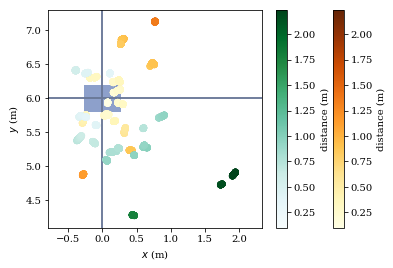

In [305]:
plot_by_distance(results, ExperimentType.Spirit, cmap="YlOrBr", crosshair=True)
plot_by_distance(results, ExperimentType.Onboard, cmap="BuGn", crosshair=True)

In [8]:
def plot_detailed(df, experiment_type, color="C0", title=None, target=TARGET,
                  alpha_point=0.5, zorder_point=1, crosshair=False,
                  xlabel="$x$ (m)", ylabel="$y$ (m)"):
    df_ex = df[df.experiment_type == experiment_type]
    df_arr = df_ex[df_ex.arrived == 1]
    if title is None:
        title = df_ex.experiment.iloc[0]
    for order in np.arange(1, df.order.max()+1):
        df_run = df_arr[df_arr.order==order]
        plt.scatter(df_run.xn, df_run.yn,
                    label=f"Run {order}", color=shade_color(color, -50+25*(order-1)))
    plot_targets(show_start=False, show_final=False, target_coords=[TARGET], crosshair=crosshair)
    plt.title(title)
    plt.axis("equal")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

In [9]:
def plot_distribution(df, experiment_type, color="C0", title=None,
                      target_color="C2", background_shade=-50, crosshair=False):
    df_ex = df[df.experiment_type == experiment_type]
    df_arr = df_ex[df_ex.arrived == 1]
    if title is None:
        title = df_ex.experiment.iloc[0]
    g = sns.jointplot(df_arr.xn, df_arr.yn, kind="kde", size=7, space=0, color=color)
    g.plot_marginals(sns.rugplot, height=0.1, color=color)
    g.ax_joint.get_children()[0].set_zorder(-1)
    for child in g.ax_joint.get_children()[1:]:
        if isinstance(child, mpl.collections.PathCollection):
            child.set_alpha(0.8)
    plt.sca(g.ax_joint)
    plot_targets(show_start=False, show_final=False, target_coords=[TARGET],
                 target_color=target_color, zorder=0, crosshair=crosshair)
    g.set_axis_labels("$x$", "$y$")
    plt.axis("equal")

    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    xsize = xmax - xmin
    ysize = ymax - ymin

    if xsize > ysize:
        ymin -= (xsize - ysize) / 2
        ymax += (xsize - ysize) / 2
        ysize = xsize
    else:
        xmin -= (ysize - xsize) / 2
        xmax += (ysize - xsize) / 2
        xsize = ysize

    plt.gca().add_patch(patches.Rectangle((xmin, ymin), xsize, ysize,
                                          color=saturate_color(color, background_shade), zorder=-1))
    g.fig.suptitle(title)

In [10]:
def plot_xy(df, x="x", y="y", invert_x=True, invert_y=True, s=None, c=None,
            cmap="viridis", alpha=1, show_cbar=True, label=None, line=False, zorder=0):
    """
    Coords in real frame. +x is towards doors, +y is away from table.
    
    """
    if s is not None:
        s = df[s]*25
    if c is not None:
        label = c
        try:
            df[c]
        except KeyError:
            pass
        else:
            c = df[c]
    else:
        if line:
            c = "C0"
        else:
            c = df.index
            label="time"
    
    if line:
        plt.plot(df[x] * (-1 if invert_x else 1), df[y] * (-1 if invert_y else 1), c=c, alpha=alpha, zorder=zorder)
    else:
        plt.scatter(df[x] * (-1 if invert_x else 1), df[y] * (-1 if invert_y else 1), s=s, c=c, cmap=cmap, alpha=alpha, zorder=zorder)
        if show_cbar:
            plt.colorbar(label=label)
    plt.axis("equal")

In [11]:
def plot_xy_conditional(df, condition=None, x="x", y="y", invert_x=True, invert_y=True,
                        s=None, c=None, c_condition=None, cmap_condition="viridis", cmap_not_condition="gray",
                        alpha_condition=1, alpha_not_condition=1, show_cbar=True, label=None, line=False,
                        zorder_condition=1, zorder_not_condition=0):
    if condition is None:
        cmap_not_condition = cmap_condition
    plot_xy(df, x=x, y=y, invert_x=invert_x, invert_y=invert_y,
            s=s, c=c, cmap=cmap_not_condition, alpha=alpha_not_condition, show_cbar=show_cbar,
            label=label, line=line, zorder=zorder_not_condition)
    if condition is not None:
        if line:
            show_cbar = False
            if c_condition is None:
                c = "C0"
            else:
                c = c_condition
        plot_xy(df[condition], x=x, y=y, invert_x=invert_x, invert_y=invert_y,
                s=s, c=c, cmap=cmap_condition, alpha=alpha_condition, show_cbar=show_cbar,
                label=label, zorder=zorder_condition)

In [12]:
def plot_targets(p_init=Coords(0, 0), p_final=Coords(0, 0), invert_x=False, invert_y=False,
                 target_coords=None, target_coord_offsets=None, target_color="C2",
                 target_size=Coords(0.525, 0.37), show_start=True, show_final=True,
                 scale=100, zorder=0, crosshair=False, background_shade=-50):
    if target_coords is not None and target_coord_offsets is not None:
        raise ValueError("Use either target_coords or target_coord_offsets")
    
    ax = plt.gca()
    
    if target_coords is None:
        if target_coord_offsets is None:
            target_coord_offsets = TARGET_COORD_OFFSETS
        target_coords = [Coords(p_init.x - offset.x, p_init.y - offset.y) for offset in target_coord_offsets]
    
    if show_start:
        plt.scatter(-p_init.x, -p_init.y, marker=(5, 0), s=100, c="g")
    for coord in target_coords:
        if crosshair:
            plt.axhline(coord.y, color=shade_color(target_color, background_shade/2), zorder=zorder)
            plt.axvline(coord.x, color=shade_color(target_color, background_shade/2), zorder=zorder)
        ax.add_patch(patches.Rectangle((coord.x * (-1 if invert_x else 1) - target_size.x / 2,
                                        coord.y * (-1 if invert_y else 1) - target_size.y / 2),
                                       target_size.x,
                                       target_size.y,
                                       color=target_color,
                                       zorder=zorder))
    if show_final:
        plt.scatter(p_final.x * (-1 if invert_x else 1), p_final.y * (-1 if invert_y else 1), marker=(3, 0), s=scale, c="r")

In [13]:
def tag_data(df):
    df["tag"] = (df.arrived.diff(1) != 0).astype('int').cumsum()

In [14]:
def distance(df, target):
    return np.sqrt((df.xn - target.x)**2 + (df.yn - target.y)**2)

In [15]:
def get_usable_filenames():
    filenames = sorted([filename for filename in glob.glob("csv/*.csv") if "user-99" not in filename])
    
    arrived_filenames = []
    for filename in filenames:
        if "user-99" not in filename:
            df = pd.read_csv(filename, parse_dates=["time"])
            if any(df.arrived):
                arrived_filenames.append(filename)
    return arrived_filenames

In [16]:
def extract_run_data(filename):
    data = filename_regex.findall(filename)[0]
    return RunData(ExperimentType(int(data[0])), int(data[1]), int(data[2]))

In [17]:
def analyze_all():
    filenames = get_usable_filenames()
    results = pd.DataFrame(columns="user experiment_type run dist_err x_err y_err".split() +
                                    "dist_std x_std y_std rms rms_x rms_y duration".split())
    
    for i, filename in enumerate(filenames):
        data = extract_run_data(filename)
        df = pd.read_csv(filename, parse_dates=["time"])
        df.xn *= -1
        df.yn *= -1
        found = df[df.arrived == 1]

        distances = distance(found, TARGET)
        dist_err = distances.mean()
        dist_std = distances.std()

        dx = found.xn - TARGET.x
        x_err = dx.mean()
        x_std = dx.std()

        dy = found.yn - TARGET.y
        y_err = dy.mean()
        y_std = dy.std()

        rms = np.sqrt(np.mean(((found.xn - TARGET.x)**2 + (found.yn - TARGET.y)**2)))
        rms_x = np.sqrt(np.mean((dx)**2))
        rms_y = np.sqrt(np.mean((dy)**2))
        
        duration = (found.time.iloc[0] - df[df.z > 0.25].time.iloc[0]).total_seconds()

        results.loc[i] = [
            data.user, data.experiment, data.run,
            dist_err, x_err, y_err,
            dist_std, x_std, y_std,
            rms, rms_x, rms_y, duration
        ]    
    return results

In [18]:
def load_all():
    filenames = get_usable_filenames()
    frames = []
    for filename in filenames:
        df = pd.read_csv(filename, parse_dates=["time"])
        data = extract_run_data(filename)
        df["experiment_type"] = data.experiment
        df["user"] = data.user
        df["run"] = data.run
        frames.append(df)
    result = pd.concat(frames, ignore_index=True)
    result.xn *= -1
    result.yn *= -1
    return result

In [19]:
def parse_tlx_component(component):
    return TlxResponse(component.code, component.score, component.weight, component.weighted_score)

In [470]:
def bestest(sample1, sample2, σ_range, exponential_m):
    y1 = np.array(sample1)
    y2 = np.array(sample2)
    y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['onboard']*len(sample1), ['spirit']*len(sample2)]))
    μ_m = y.value.mean()
    μ_s = y.value.std() * 2

    with pm.Model() as model:
        group1_mean = pm.Normal('group1_mean', μ_m, sd=μ_s)
        group2_mean = pm.Normal('group2_mean', μ_m, sd=μ_s)
        σ_low, σ_high = σ_range
        group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
        group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)
        ν = pm.Exponential('ν_minus_one', abs(1/(exponential_m-1))) + 1    
        
        λ1 = group1_std**-2
        λ2 = group2_std**-2

        group1 = pm.StudentT('onboard', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
        group2 = pm.StudentT('spirit', nu=ν, mu=group2_mean, lam=λ2, observed=y2)
        
        diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
        diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
        effect_size = pm.Deterministic('effect size',
                                       diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))
        trace = pm.sample(2000, init=None, njobs=2)
    return trace

In [471]:
def summarize(trace, kde=True):
    ax = pm.plot_posterior(trace[100:],
                           varnames=[r'group1_mean', r'group2_mean',
                                     r'group1_std', 'group2_std',
                                     r'ν_minus_one'],
                           kde_plot=kde, color="C0");
    if kde:
        for a in (1, 3):
            ax[a].lines[0].set_color("C1")
    plt.figure()
    pm.plot_posterior(trace[1000:],
                      varnames=['difference of means', 'difference of stds', 'effect size'],
                      ref_val=0, kde_plot=True, color="C2");
    plt.figure()
    pm.forestplot(trace[1000:], varnames=[v.name for v in model.vars[:2]]);
    plt.figure()
    pm.forestplot(trace[1000:], varnames=[v.name for v in model.vars[2:]])
    pm.summary(trace[1000:],
                     varnames=['difference of means', 'difference of stds', 'effect size'])

Import the files.

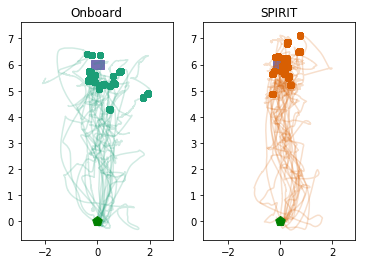

In [488]:
ax1 = plt.subplot("121")
for filename in glob.glob("csv/experiment-1_*.csv"):
    if "user-99" not in filename:
        df = pd.read_csv(filename, parse_dates=["time"])
        if any(df.arrived):
            plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C0", c_condition="C0",
                                alpha_not_condition=0.2, alpha_condition=0.5, line=True,
                                zorder_condition=1, zorder_not_condition=0)
plot_targets(target_coords=[TARGET], show_final=False, zorder=-1)
plt.title("Onboard")

ax2 = plt.subplot("122", sharex=ax1, sharey=ax1)
for filename in glob.glob("csv/experiment-2_*.csv"):
    if "user-99" not in filename:
        df = pd.read_csv(filename, parse_dates=["time"])
        if any(df.arrived):
            plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C1", c_condition="C1",
                                alpha_not_condition=0.2, alpha_condition=0.5, line=True,
                                zorder_condition=1, zorder_not_condition=0)
plot_targets(target_coords=[TARGET], show_final=False, zorder=-1)
plt.title("SPIRIT")

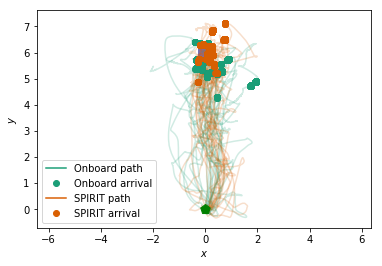

In [489]:
for filename in glob.glob("csv/experiment-1_*.csv"):
    if "user-99" not in filename:
        df = pd.read_csv(filename, parse_dates=["time"])
        if any(df.arrived):
            plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C0", c_condition="C0",
                                alpha_not_condition=0.2, alpha_condition=0.5, line=True,
                                zorder_condition=1, zorder_not_condition=0)
onboard_path, = plt.plot([], [], color="C0", label="Onboard path")
onboard_arrival, = plt.plot([], [], linestyle="none", color="C0", marker="o", label="Onboard arrival")
for filename in glob.glob("csv/experiment-2_*.csv"):
    if "user-99" not in filename:
        df = pd.read_csv(filename, parse_dates=["time"])
        if any(df.arrived):
            plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C1", c_condition="C1",
                                alpha_not_condition=0.2, alpha_condition=0.5, line=True,
                                zorder_condition=1, zorder_not_condition=0)
spirit_path, = plt.plot([], [], color="C1", label="SPIRIT path")
spirit_arrival, = plt.plot([], [], linestyle="none", color="C1", marker="o", label="SPIRIT arrival")
plot_targets(target_coords=[TARGET], show_final=False, zorder=-1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend(handles=[onboard_path, onboard_arrival, spirit_path, spirit_arrival])

Check not too many multiple arrivals.

In [111]:
filenames = get_usable_filenames()
filenames

['csv/experiment-1_user-00_run-00.csv',
 'csv/experiment-1_user-00_run-01.csv',
 'csv/experiment-1_user-01_run-00.csv',
 'csv/experiment-1_user-01_run-01.csv',
 'csv/experiment-1_user-02_run-00.csv',
 'csv/experiment-1_user-02_run-02.csv',
 'csv/experiment-1_user-03_run-00.csv',
 'csv/experiment-1_user-03_run-01.csv',
 'csv/experiment-1_user-04_run-00.csv',
 'csv/experiment-1_user-04_run-01.csv',
 'csv/experiment-1_user-05_run-01.csv',
 'csv/experiment-1_user-05_run-02.csv',
 'csv/experiment-1_user-06_run-00.csv',
 'csv/experiment-1_user-06_run-01.csv',
 'csv/experiment-1_user-07_run-00.csv',
 'csv/experiment-1_user-07_run-01.csv',
 'csv/experiment-2_user-00_run-00.csv',
 'csv/experiment-2_user-00_run-01.csv',
 'csv/experiment-2_user-01_run-00.csv',
 'csv/experiment-2_user-01_run-01.csv',
 'csv/experiment-2_user-02_run-00.csv',
 'csv/experiment-2_user-02_run-01.csv',
 'csv/experiment-2_user-03_run-00.csv',
 'csv/experiment-2_user-03_run-03.csv',
 'csv/experiment-2_user-04_run-00.csv',


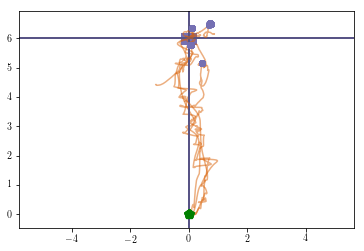

In [20]:
for filename in glob.glob("csv/experiment-*_user-07*.csv"):
    df = pd.read_csv(filename, parse_dates=["time"])
    plot_targets(target_coords=[TARGET], show_final=False, zorder=0, crosshair=True)
    plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C1", c_condition="C2",
                        alpha_not_condition=0.5, alpha_condition=0.5, line=True)

# Mega dataframe

In [20]:
analyses = analyze_all()
results = load_all()

In [21]:
analyses["group"] = (analyses.user % 2).astype(int)
analyses["start"] = [ExperimentType(e % 2 + 1) for e in analyses.user]
analyses["experiment_int"] = [e.value for e in analyses.experiment_type]
analyses["experiment"] = [e.name for e in analyses.experiment_type]
analyses.experiment.replace("Spirit", "SPIRIT", inplace=True)

results["group"] = (results.user % 2).astype(int)
results["start"] = [ExperimentType(e % 2 + 1) for e in results.user]
results["experiment_int"] = [e.value for e in results.experiment_type]
results["experiment"] = [e.name for e in results.experiment_type]
results.experiment.replace("Spirit", "SPIRIT", inplace=True)
results["distance"] = distance(results, TARGET)
results["dx"] = results.xn - TARGET.x
results["dy"] = results.yn - TARGET.y
results["total_ordering"] = ((results.run.diff(1) != 0)
                             | (results.experiment_int.diff(1) != 0)
                             | (results.user.diff(1) != 0)).astype('int').cumsum() - 1

In [22]:
for user in set(analyses.user):
    _df = analyses[analyses.user == user].sort_values(by="experiment_int", ascending=np.all(analyses[analyses.user==user].start==ExperimentType.Onboard))
    _df["order"] = range(1, len(_df) + 1)
    for idx in _df.index:
        analyses.loc[idx, "order"] = int(_df.loc[idx, "order"])
        results.loc[results.total_ordering==idx, "order"] = int(_df.loc[idx, "order"])

In [23]:
for col in ["user", "run", "group", "order"]:
    analyses[col] = analyses[col].astype(int)
for col in ["arrived", "order"]:
    results[col] = results[col].astype(int)

In [24]:
spirit_arrived = results[(results.arrived==1) & (results.experiment_type==ExperimentType.Spirit)]
onboard_arrived = results[(results.arrived==1) & (results.experiment_type==ExperimentType.Onboard)]

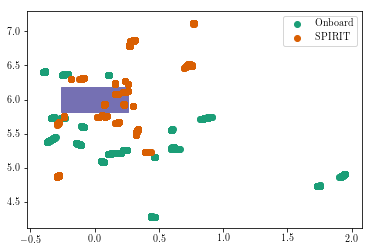

In [1160]:
plt.scatter(onboard_arrived.xn, onboard_arrived.yn, label="Onboard")
plt.scatter(spirit_arrived.xn, spirit_arrived.yn, label="SPIRIT")
plot_targets(show_start=False, show_final=False, target_coords=[TARGET])
plt.legend()

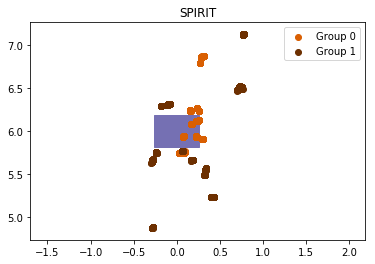

In [632]:
plt.scatter(spirit_arrived[spirit_arrived.start==ExperimentType.Onboard].xn,
            spirit_arrived[spirit_arrived.start==ExperimentType.Onboard].yn,
            c="C1", label="Group 0")
plt.scatter(spirit_arrived[spirit_arrived.start==ExperimentType.Spirit].xn,
            spirit_arrived[spirit_arrived.start==ExperimentType.Spirit].yn,
            c=shade_color("C1", -50), label="Group 1")
plot_targets(show_start=False, show_final=False, target_coords=[TARGET])
plt.title("SPIRIT")
plt.legend()

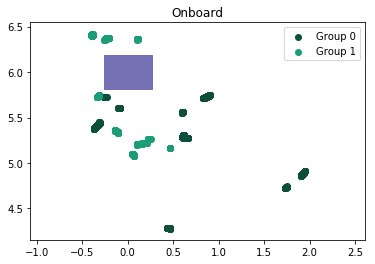

In [633]:
plt.scatter(onboard_arrived[onboard_arrived.group==0].xn,
            onboard_arrived[onboard_arrived.group==0].yn,
            c=shade_color("C0", -50), label="Group 0")
plt.scatter(onboard_arrived[onboard_arrived.group==1].xn,
            onboard_arrived[onboard_arrived.group==1].yn,
            c="C0", label="Group 1")
plot_targets(show_start=False, show_final=False, target_coords=[TARGET])
plt.title("Onboard")
plt.legend()

(-0.35671556917940106,
 0.83579532867796602,
 4.7432750819855078,
 7.253605687744491)

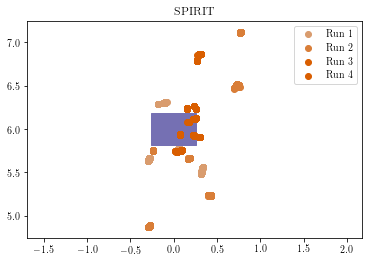

In [101]:
plt.scatter(spirit_arrived[spirit_arrived.order==1].xn, spirit_arrived[spirit_arrived.order==1].yn, label="Run 1", c=saturate_color("C1", -50))
plt.scatter(spirit_arrived[spirit_arrived.order==2].xn, spirit_arrived[spirit_arrived.order==2].yn, label="Run 2", c=saturate_color("C1", -25))
plt.scatter(spirit_arrived[spirit_arrived.order==3].xn, spirit_arrived[spirit_arrived.order==3].yn, label="Run 3", c=saturate_color("C1", 10))
plt.scatter(spirit_arrived[spirit_arrived.order==4].xn, spirit_arrived[spirit_arrived.order==4].yn, label="Run 4", c=saturate_color("C1", 50))
plot_targets(show_start=False, show_final=False, target_coords=[TARGET])
plt.title("SPIRIT")
plt.legend()
plt.axis("equal")

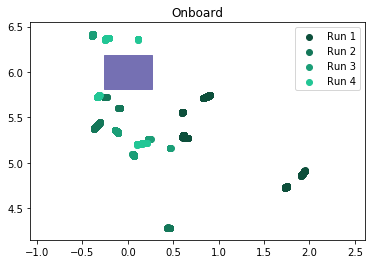

In [640]:
plt.scatter(onboard_arrived[onboard_arrived.order==1].xn, onboard_arrived[onboard_arrived.order==1].yn, label="Run 1", c=shade_color("C0", -50))
plt.scatter(onboard_arrived[onboard_arrived.order==2].xn, onboard_arrived[onboard_arrived.order==2].yn, label="Run 2", c=shade_color("C0", -25))
plt.scatter(onboard_arrived[onboard_arrived.order==3].xn, onboard_arrived[onboard_arrived.order==3].yn, label="Run 3", c=shade_color("C0", 0))
plt.scatter(onboard_arrived[onboard_arrived.order==4].xn, onboard_arrived[onboard_arrived.order==4].yn, label="Run 4", c=shade_color("C0", 25))
plot_targets(show_start=False, show_final=False, target_coords=[TARGET])
plt.title("Onboard")
plt.legend()

In [642]:
analyses[analyses.user == 6].sort_values

<bound method DataFrame.sort_values of     user              experiment  run   dist_err     x_err     y_err  \
12   6.0  ExperimentType.Onboard  0.0  11.322550 -0.611649  0.693983   
13   6.0  ExperimentType.Onboard  1.0  11.728489  0.252302  0.274229   
28   6.0   ExperimentType.Spirit  2.0  11.754809 -0.087296  0.245515   
29   6.0   ExperimentType.Spirit  3.0  11.920676 -0.270667  0.082450   

    dist_std     x_std     y_std       rms     rms_x     rms_y   duration  \
12  0.003611  0.003397  0.003434  0.925068  0.611658  0.693991  23.331129   
13  0.001770  0.008907  0.001584  0.372745  0.252457  0.274233  45.919718   
28  0.004243  0.003775  0.004216  0.260633  0.087376  0.245551  61.347842   
29  0.010691  0.035311  0.011451  0.285352  0.272942  0.083235  40.722825   

    group                   start  experiment_int  order  
12    0.0  ExperimentType.Onboard               1    1.0  
13    0.0  ExperimentType.Onboard               1    2.0  
28    0.0  ExperimentType.Onboard    

In [643]:
analyses[analyses.group == 0].rms.mean()

0.67435106579040993

In [644]:
analyses[analyses.group == 1].rms.mean()

0.63270993517112506

In [645]:
analyses[analyses.experiment_type == ExperimentType.Spirit].dist_err.mean()

11.966150697499852

In [646]:
analyses[analyses.experiment_type == ExperimentType.Onboard].rms.mean()

0.83362377161648848

In [647]:
analyses[(analyses.experiment_type == ExperimentType.Spirit) & (analyses.group == 0)].rms.mean()

0.32309553774994576

In [648]:
analyses[(analyses.experiment_type == ExperimentType.Spirit) & (analyses.group == 1)].rms.mean()

0.6237789209401472

In [649]:
analyses[(analyses.experiment_type == ExperimentType.Onboard) & (analyses.group == 0)].rms.mean()

1.0256065938308743

In [650]:
analyses[(analyses.experiment_type == ExperimentType.Onboard) & (analyses.group == 1)].rms.mean()

0.64164094940210281

In [651]:
plt.get_cmap("Dark2").colors

((0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4))

In [652]:
dt=analyses.duration.iloc[0]

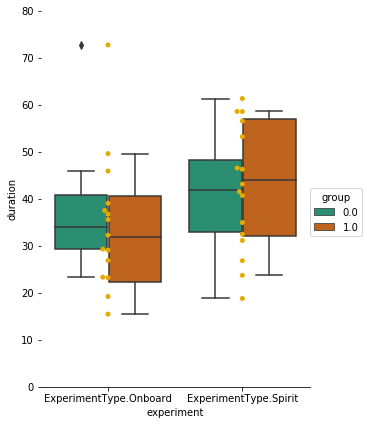

In [653]:
g = sns.factorplot(x="experiment", y="duration", data=analyses, hue="group",
                   size=6, aspect=.75, kind="box")
sns.swarmplot(x="experiment", y="duration", data=analyses, color="C5")
plt.ylim(0, 80)
g.despine(left=True)

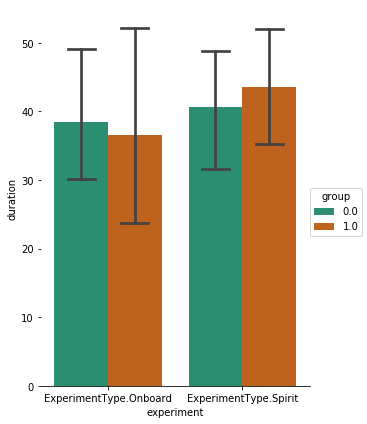

In [655]:
g = sns.factorplot(x="experiment", y="duration", data=analyses, hue="group",
                   capsize=.2, size=6, aspect=.75, kind="bar")
g.despine(left=True)

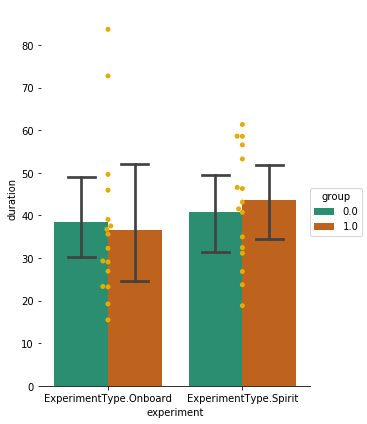

In [658]:
g = sns.factorplot(x="experiment", y="duration", data=analyses, hue="group",
                   capsize=.2, size=6, aspect=.75, kind="bar")
sns.swarmplot(x="experiment", y="duration", data=analyses, color="C5")
g.despine(left=True)

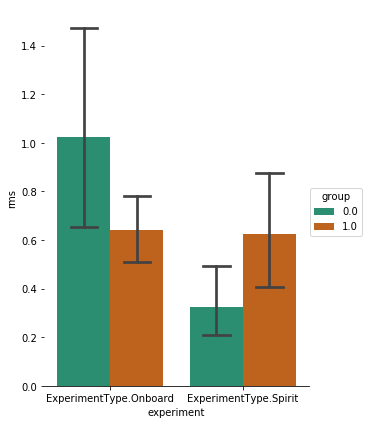

In [659]:
g = sns.factorplot(x="experiment", y="rms", data=analyses, hue="group",
                   capsize=.2, size=6, aspect=.75, kind="bar")
g.despine(left=True)

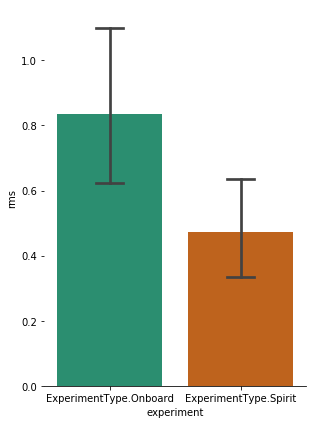

In [660]:
g = sns.factorplot(x="experiment", y="rms", data=analyses,
                   capsize=.2, size=6, aspect=.75, kind="bar")
g.despine(left=True)

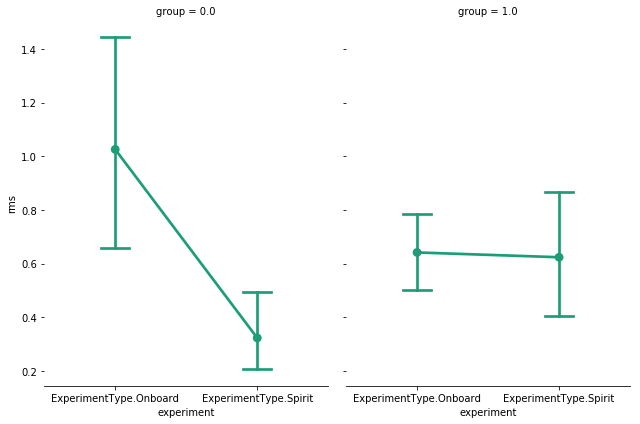

In [661]:
g = sns.factorplot(x="experiment", y="rms", col="group", data=analyses,
                   capsize=.2, size=6, aspect=.75)
g.despine(left=True)

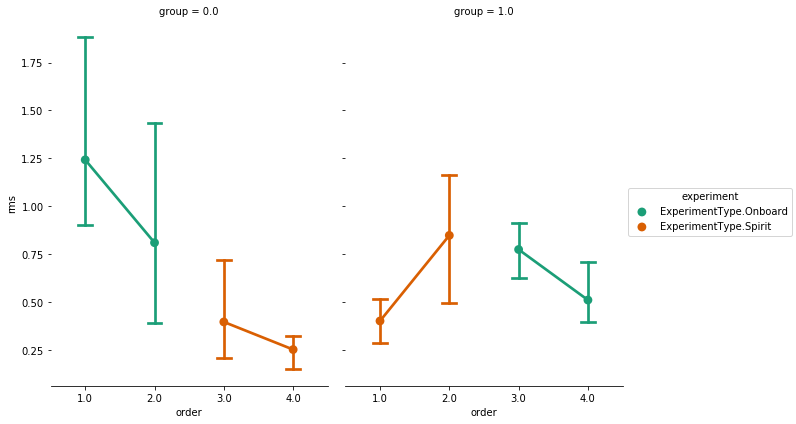

In [662]:
g = sns.factorplot(x="order", y="rms", col="group", hue="experiment", data=analyses,
                   capsize=.2, size=6, aspect=.75)
g.despine(left=True)

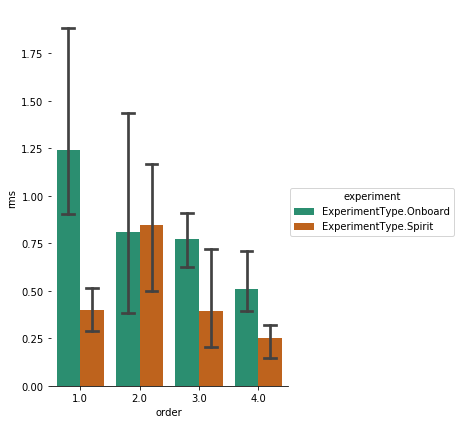

In [663]:
g = sns.factorplot(x="order", y="rms", hue="experiment", data=analyses,
                   capsize=.2, size=6, aspect=.75, kind="bar")
g.despine(left=True)

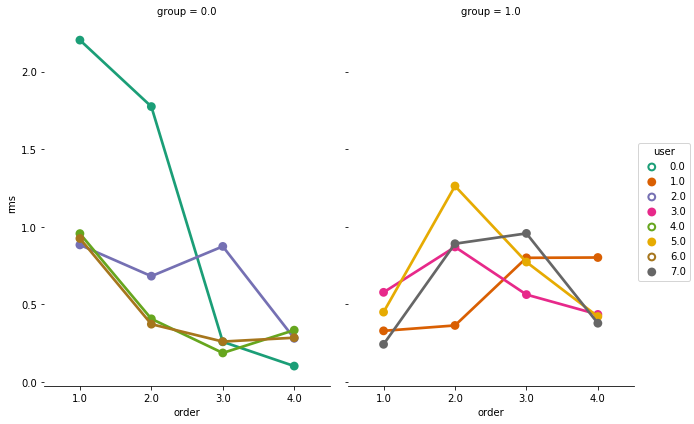

In [664]:
g = sns.factorplot(x="order", y="rms", hue="user", col="group", data=analyses,
                   capsize=.2, size=6, aspect=.75)
g.despine(left=True)

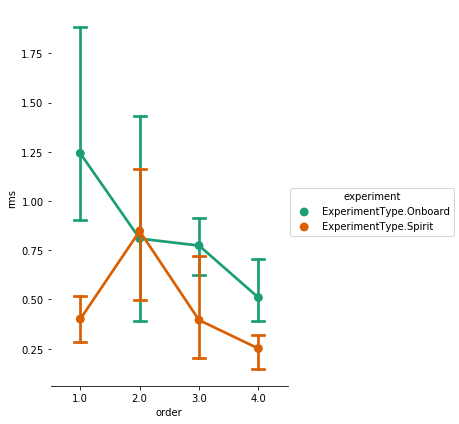

In [666]:
g = sns.factorplot(x="order", y="rms", hue="experiment", data=analyses,
                   capsize=.2, size=6, aspect=.75)
g.despine(left=True)

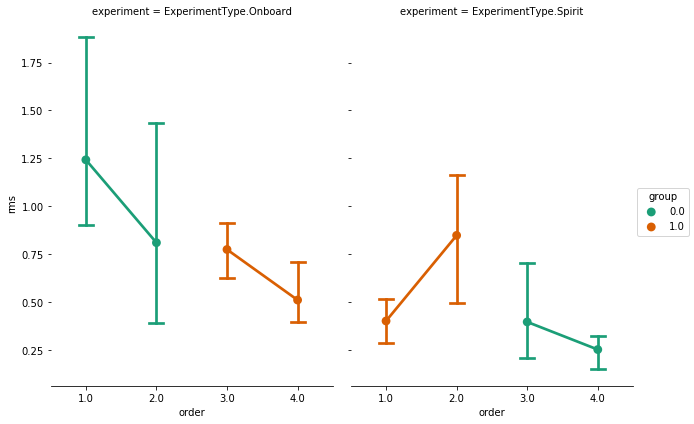

In [259]:
g = sns.factorplot(x="order", y="rms", hue="group", col="experiment", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

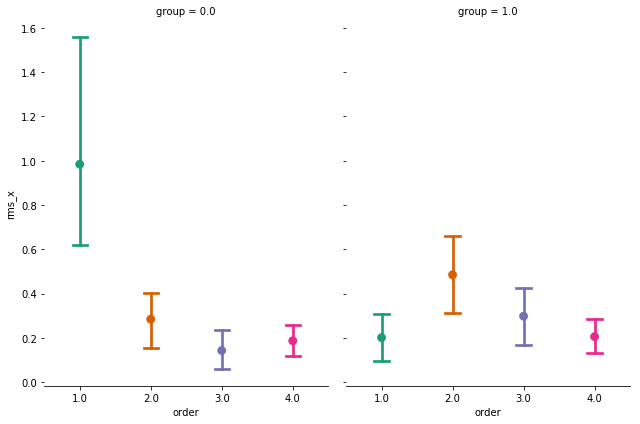

In [260]:
g = sns.factorplot(x="order", y="rms_x", col="group", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

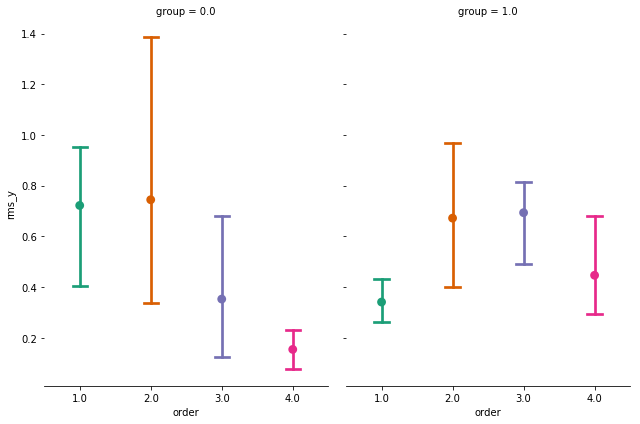

In [261]:
g = sns.factorplot(x="order", y="rms_y", col="group", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

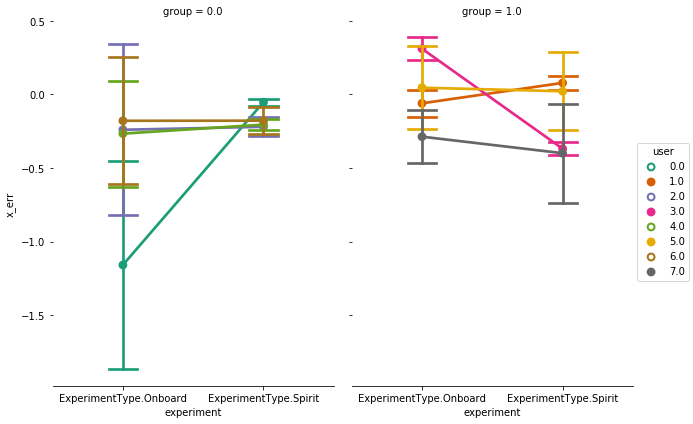

In [262]:
g = sns.factorplot(x="experiment", y="x_err", col="group", hue="user", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

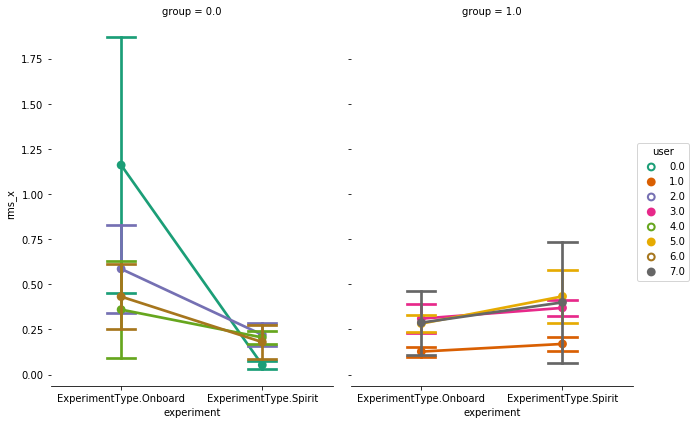

In [263]:
g = sns.factorplot(x="experiment", y="rms_x", col="group", hue="user", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

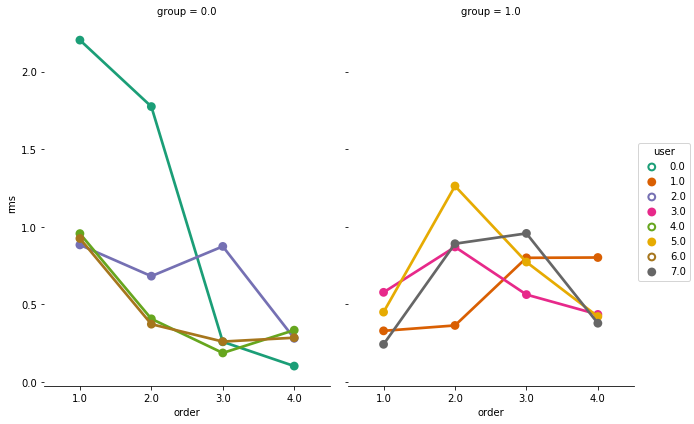

In [264]:
g = sns.factorplot(x="order", y="rms", col="group", hue="user", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

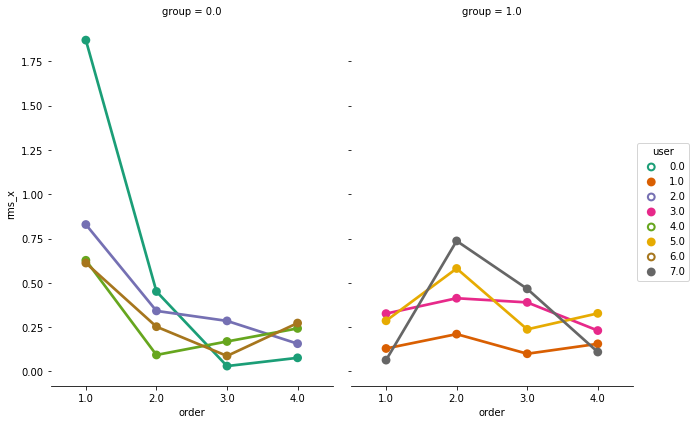

In [270]:
g = sns.factorplot(x="order", y="rms_x", col="group", hue="user", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

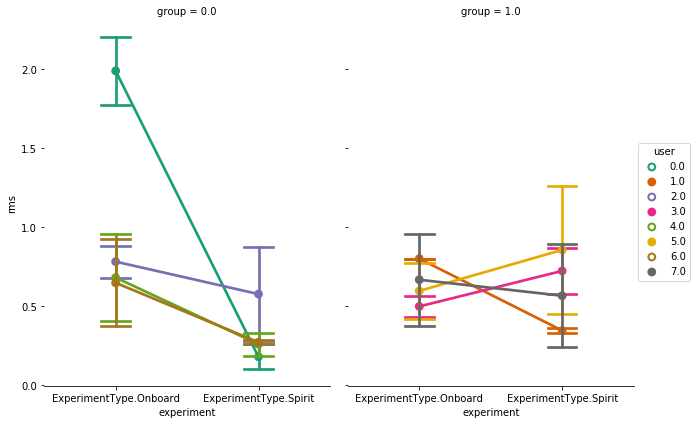

In [271]:
g = sns.factorplot(x="experiment", y="rms", col="group", hue="user", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

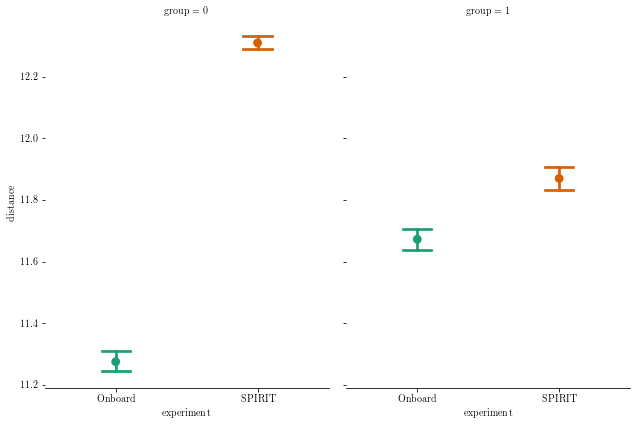

In [1098]:
g = sns.factorplot(x="experiment", y="distance", col="group", data=results[results.arrived==1],
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

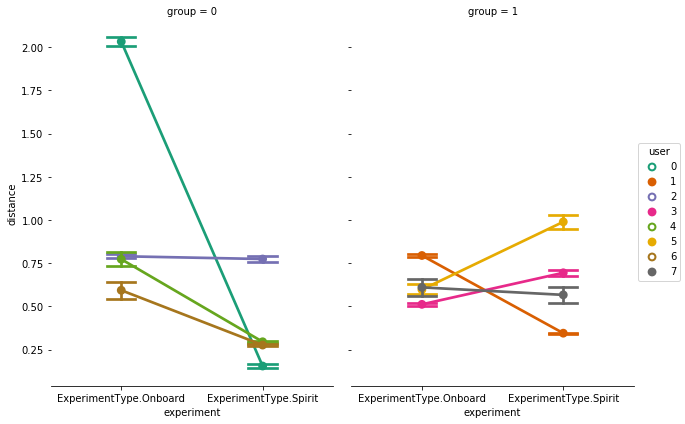

In [273]:
g = sns.factorplot(x="experiment", y="distance", col="group", hue="user", data=results[results.arrived==1],
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

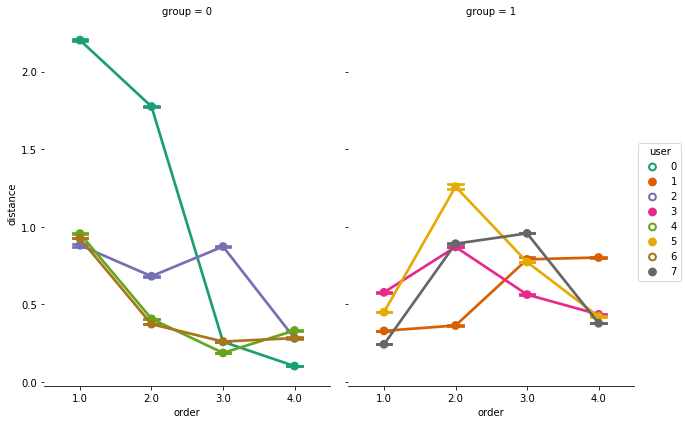

In [274]:
g = sns.factorplot(x="order", y="distance", col="group", hue="user", data=results[results.arrived==1],
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

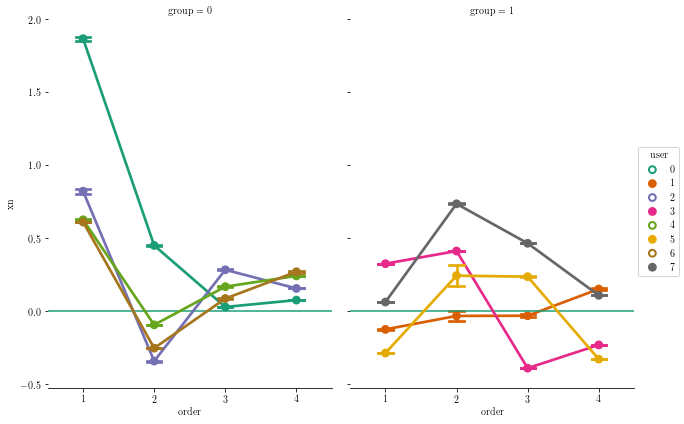

In [85]:
g = sns.factorplot(x="order", y="xn", col="group", hue="user", data=results[results.arrived==1],
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)
g.axes[0][0].axhline(0)
g.axes[0][1].axhline(0)

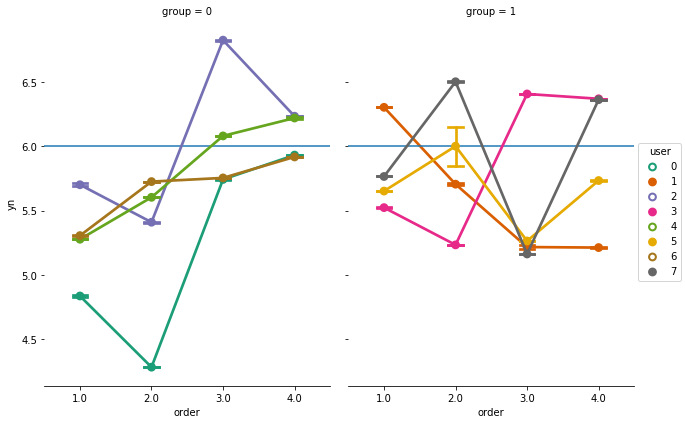

In [276]:
g = sns.factorplot(x="order", y="yn", col="group", hue="user", data=results[results.arrived==1],
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)
g.axes[0][0].axhline(6)
g.axes[0][1].axhline(6)

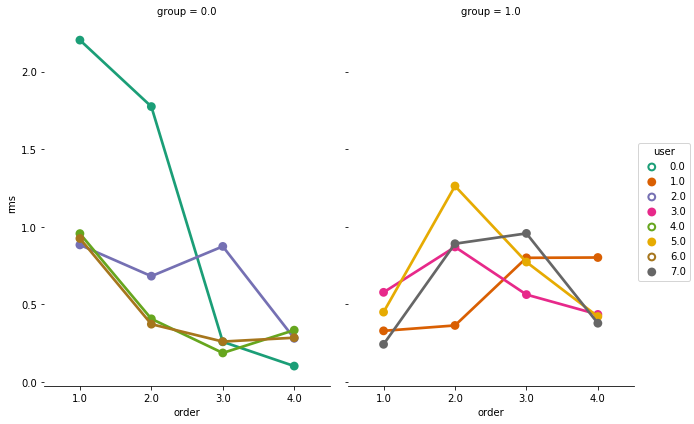

In [277]:
g = sns.factorplot(x="order", y="rms", col="group", hue="user", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

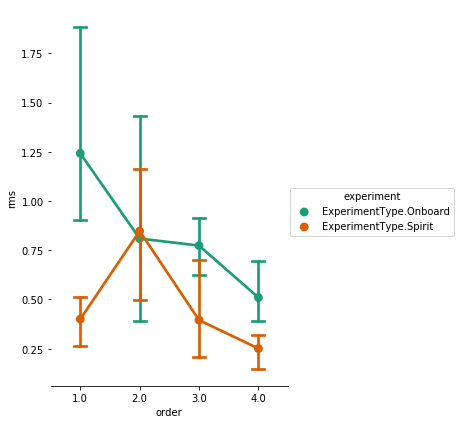

In [278]:
g = sns.factorplot(x="order", y="rms", hue="experiment", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

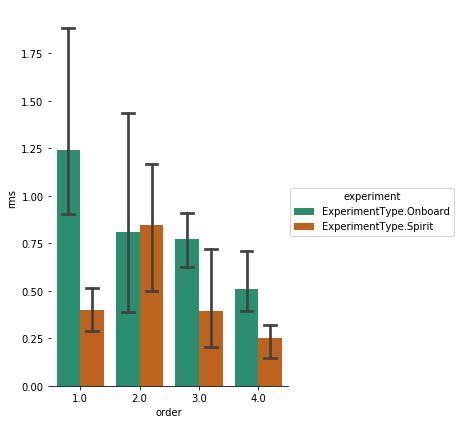

In [279]:
g = sns.factorplot(x="order", y="rms", hue="experiment", data=analyses,
                   capsize=.2, palette="Dark2", size=6, aspect=.75, kind="bar")
g.despine(left=True)

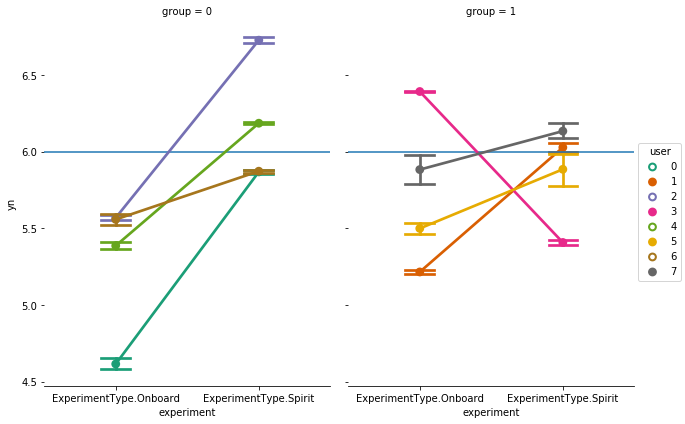

In [280]:
g = sns.factorplot(x="experiment", y="yn", col="group", hue="user", data=results[results.arrived==1],
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)
g.axes[0][0].axhline(6)
g.axes[0][1].axhline(6)

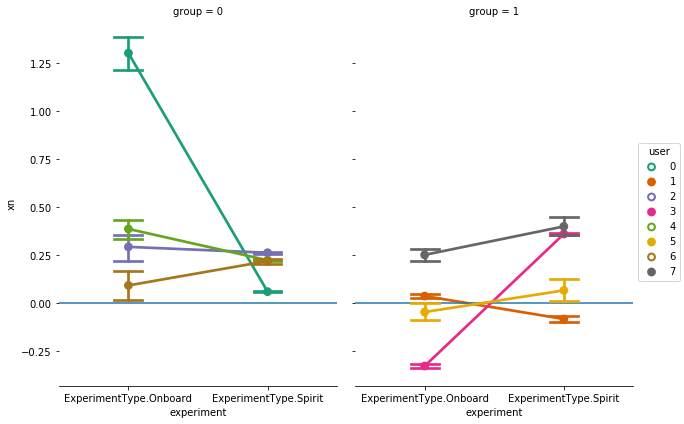

In [281]:
g = sns.factorplot(x="experiment", y="xn", col="group", hue="user", data=results[results.arrived==1],
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)
g.axes[0][0].axhline(0)
g.axes[0][1].axhline(0)

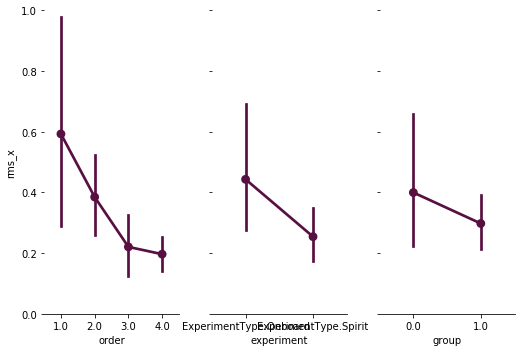

In [282]:
g = sns.PairGrid(analyses, y_vars="rms_x",
                 x_vars=["order", "experiment", "group"],
                 size=5, aspect=.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)

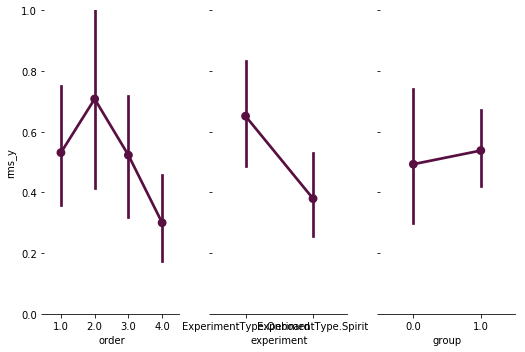

In [283]:
g = sns.PairGrid(analyses, y_vars="rms_y",
                 x_vars=["order", "experiment", "group"],
                 size=5, aspect=.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)

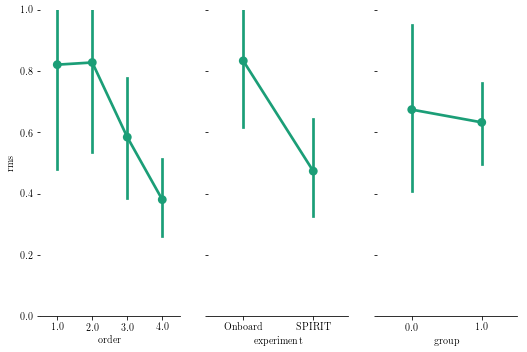

In [1029]:
g = sns.PairGrid(analyses, y_vars="rms",
                 x_vars=["order", "experiment", "group"],
                 size=5, aspect=.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot)
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)

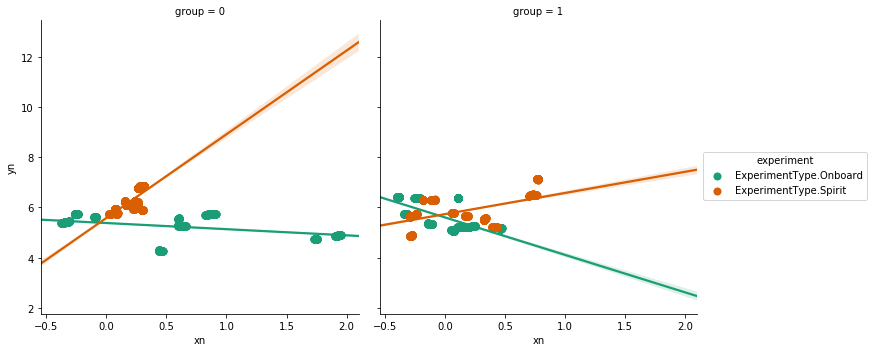

In [64]:
sns.lmplot(x="xn", y="yn", col="group", hue="experiment", data=results[results.arrived==1],
           col_wrap=2, palette="Dark2",
           scatter_kws={"s": 50, "alpha": 1})

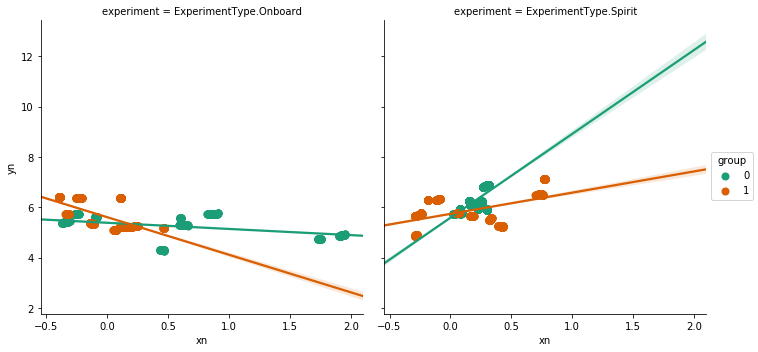

In [65]:
sns.lmplot(x="xn", y="yn", col="experiment", hue="group", data=results[results.arrived==1],
           col_wrap=2, palette="Dark2",
           scatter_kws={"s": 50, "alpha": 1})

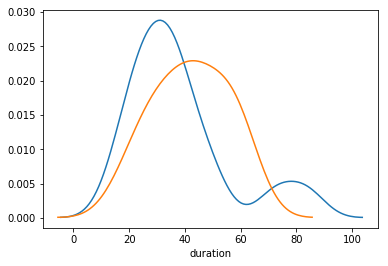

In [414]:
sns.distplot(analyses[analyses.experiment_type==ExperimentType.Onboard].duration, hist=False)
sns.distplot(analyses[analyses.experiment_type==ExperimentType.Spirit].duration, hist=False)

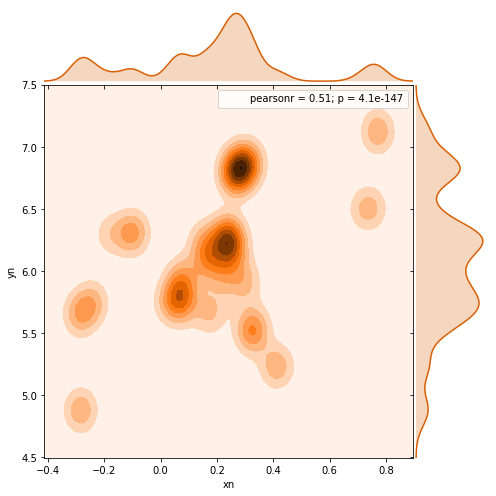

In [788]:
g = sns.jointplot(spirit_arrived.xn, spirit_arrived.yn, kind="kde", size=7, space=0, color="C1")

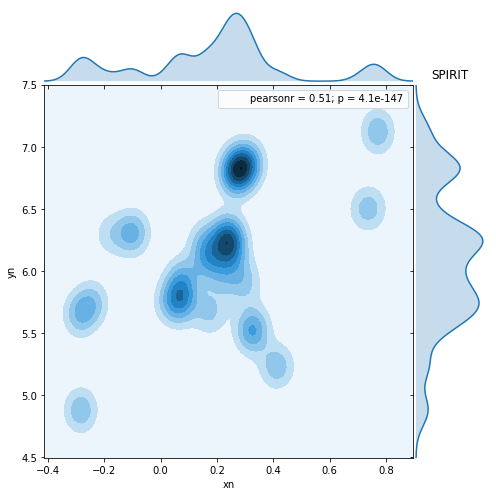

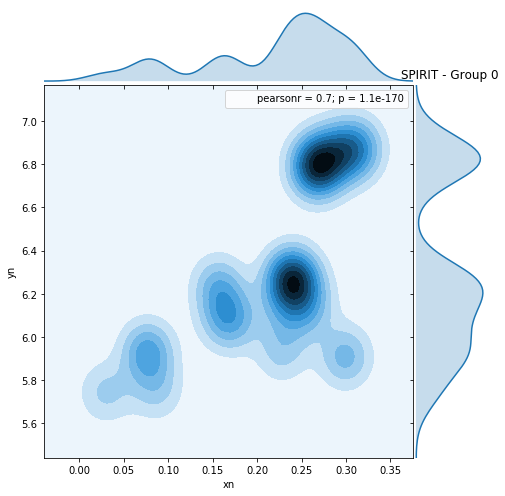

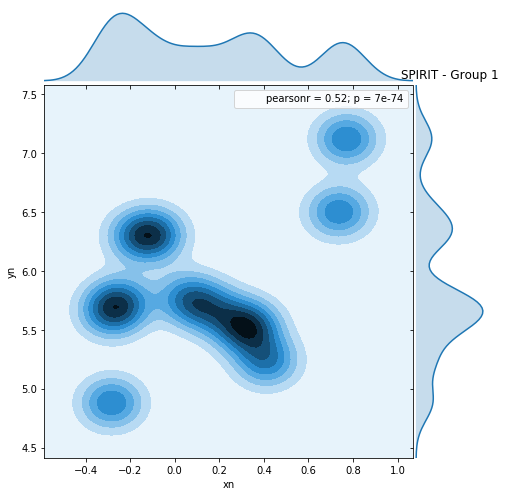

In [66]:
g = sns.jointplot(spirit_arrived.xn, spirit_arrived.yn, kind="kde", size=7, space=0)
plt.title("SPIRIT")
g = sns.jointplot(spirit_arrived[spirit_arrived.group==0].xn, spirit_arrived[spirit_arrived.group==0].yn, kind="kde", size=7, space=0)
plt.title("SPIRIT - Group 0")
g = sns.jointplot(spirit_arrived[spirit_arrived.group==1].xn, spirit_arrived[spirit_arrived.group==1].yn, kind="kde", size=7, space=0)
plt.title("SPIRIT - Group 1")

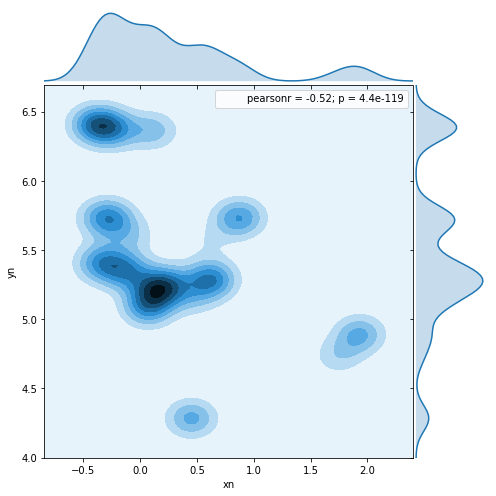

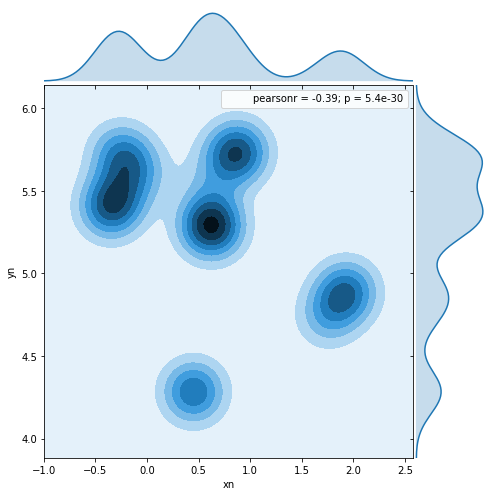

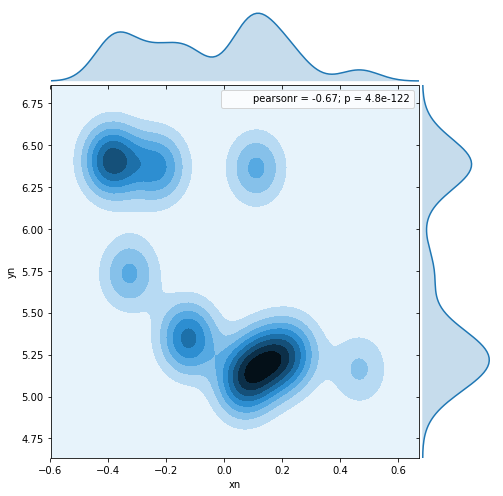

In [67]:
g = sns.jointplot(onboard_arrived.xn, onboard_arrived.yn, kind="kde", size=7, space=0)
g = sns.jointplot(onboard_arrived[onboard_arrived.group==0].xn, onboard_arrived[onboard_arrived.group==0].yn, kind="kde", size=7, space=0)
g = sns.jointplot(onboard_arrived[onboard_arrived.group==1].xn, onboard_arrived[onboard_arrived.group==1].yn, kind="kde", size=7, space=0)

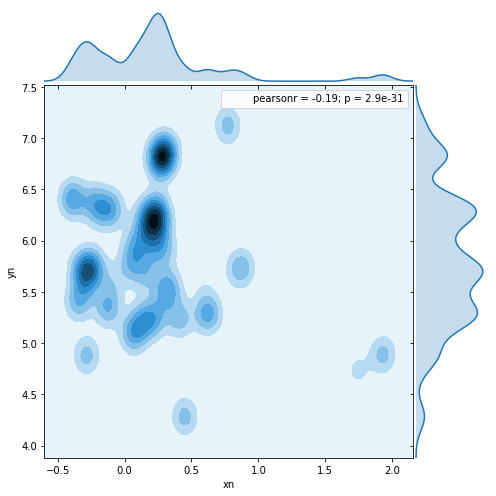

In [27]:
g = sns.jointplot(results[results.arrived==1].xn, results[results.arrived==1].yn, kind="kde", size=7, space=0)
# g.plot_marginals(sns.rugplot, height=0.1

In [193]:
analyses["experiment_int"] = [e.value for e in analyses.experiment]
results["experiment_int"] = [e.value for e in results.experiment]

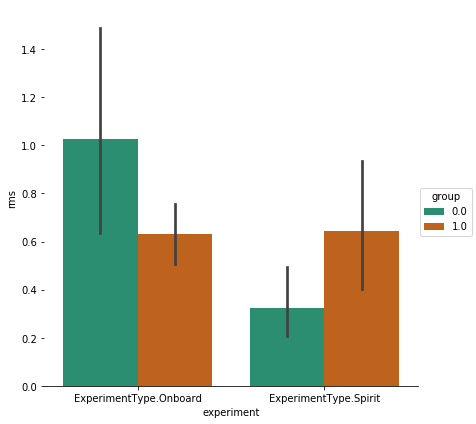

In [185]:
g = sns.factorplot(x="experiment", y="rms", hue="group", data=analyses,
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

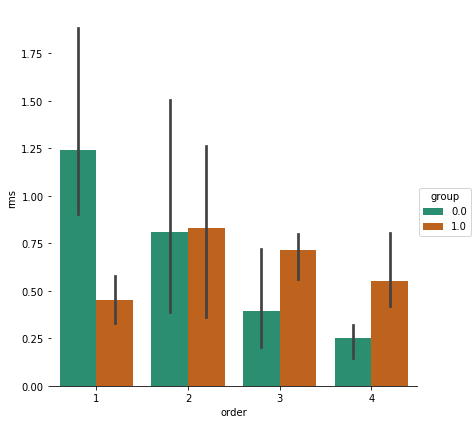

In [186]:
g = sns.factorplot(x="order", y="rms", hue="group", data=analyses,
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

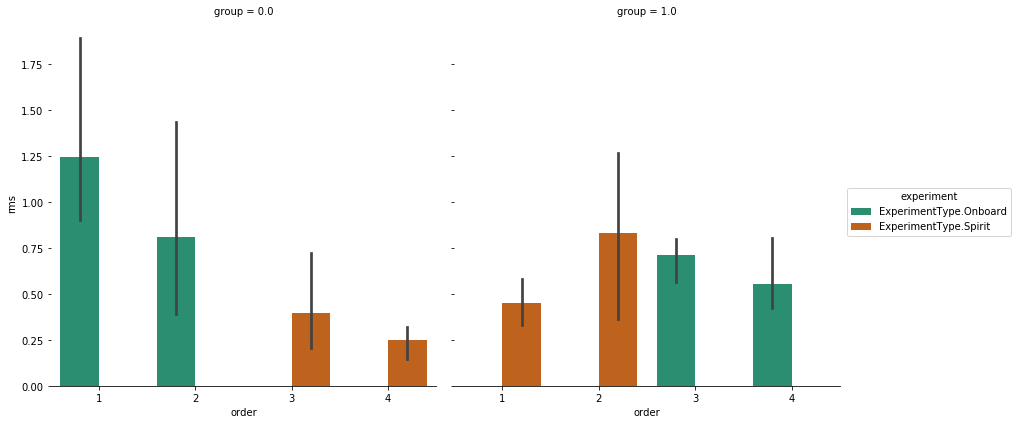

In [187]:
g = sns.factorplot(x="order", y="rms", hue="experiment", col="group", data=analyses,
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

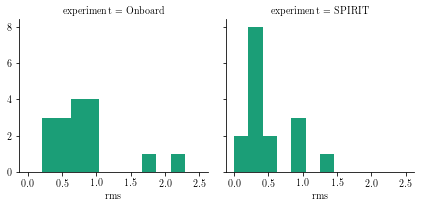

In [1030]:
g = sns.FacetGrid(analyses, col="experiment", margin_titles=True)
bins = np.linspace(0, 2.5, 13)
g.map(plt.hist, "rms", bins=bins, lw=0)

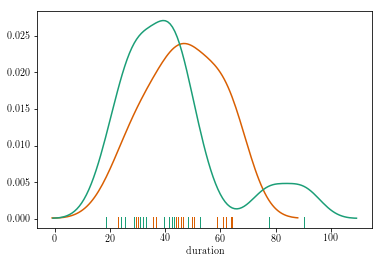

In [1186]:
sns.distplot(analyses[analyses.experiment_type == ExperimentType.Spirit].duration, hist=False, rug=True, color="C1")
sns.distplot(analyses[analyses.experiment_type == ExperimentType.Onboard].duration, hist=False, rug=True, color="C0")

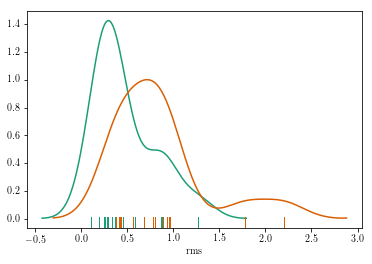

In [1187]:
sns.distplot(analyses[analyses.experiment_type == ExperimentType.Spirit].rms, hist=False, rug=True, color="C0")
sns.distplot(analyses[analyses.experiment_type == ExperimentType.Onboard].rms, hist=False, rug=True, color="C1")

In [291]:
analyses[analyses.experiment_type == ExperimentType.Spirit].rms.mean()

0.47343722934504651

In [292]:
analyses[analyses.experiment_type == ExperimentType.Onboard].rms.mean()

0.83362377161648848

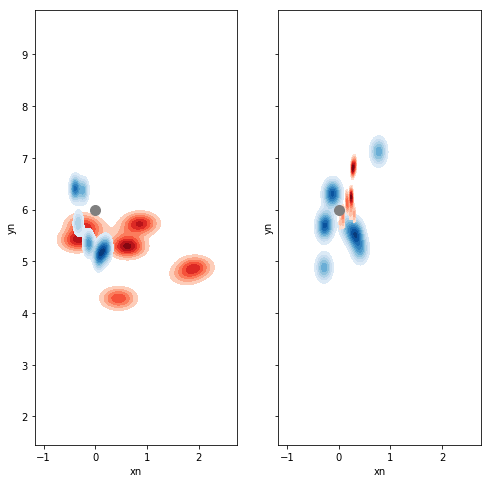

In [68]:
f, axes = plt.subplots(1, 2, figsize=(8, 8), sharex=True, sharey=True)
axes[0].set_aspect("equal")
axes[1].set_aspect("equal")

sns.kdeplot(onboard_arrived[onboard_arrived.group==0].xn, onboard_arrived[onboard_arrived.group==0].yn,
            cmap="Reds", shade=True, shade_lowest=False, ax=axes[0])
sns.kdeplot(onboard_arrived[onboard_arrived.group==1].xn, onboard_arrived[onboard_arrived.group==1].yn,
            cmap="Blues", shade=True, shade_lowest=False, ax=axes[0])

axes[0].scatter(0, 6, c="C7", s=100)

sns.kdeplot(spirit_arrived[spirit_arrived.group==1].xn, spirit_arrived[spirit_arrived.group==1].yn,
            cmap="Blues", shade=True, shade_lowest=False, ax=axes[1])
sns.kdeplot(spirit_arrived[spirit_arrived.group==0].xn, spirit_arrived[spirit_arrived.group==0].yn,
            cmap="Reds", shade=True, shade_lowest=False, ax=axes[1])

axes[1].scatter(0, 6, c="C7", s=100)

/home/masasin/.pyenv/versions/3.6.0/envs/scipy_stack/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


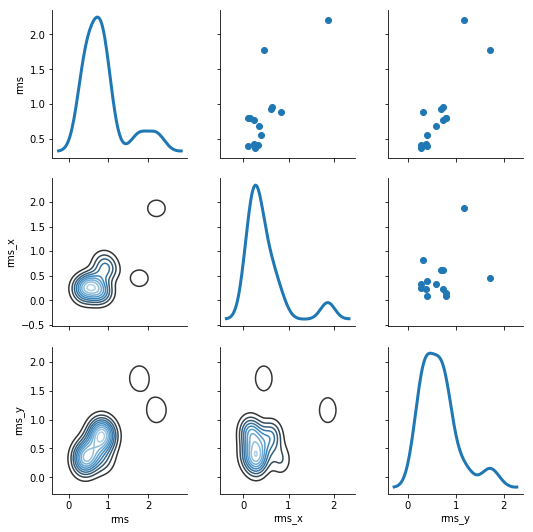

In [84]:
g = sns.PairGrid(analyses[analyses.experiment_type==ExperimentType.Onboard][["rms", "rms_x", "rms_y"]], diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

/home/masasin/.pyenv/versions/3.6.0/envs/scipy_stack/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


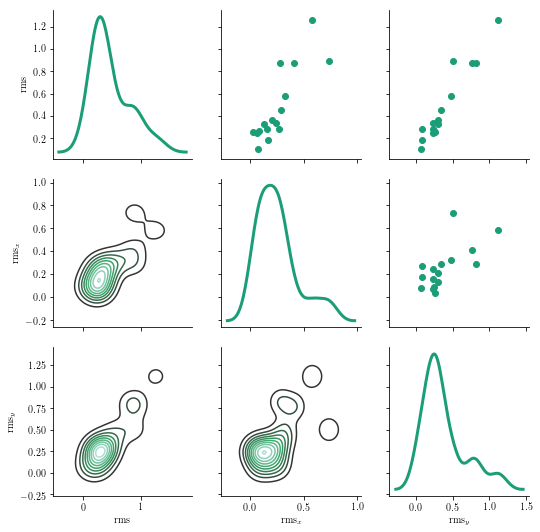

In [38]:
g = sns.PairGrid(analyses[analyses.experiment_type==ExperimentType.Spirit][["rms", "rms_x", "rms_y"]], diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

/home/masasin/.pyenv/versions/3.6.0/envs/scipy_stack/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


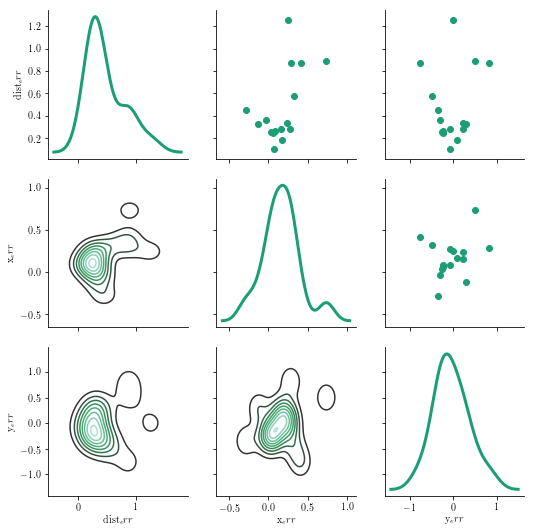

In [40]:
g = sns.PairGrid(analyses[analyses.experiment_type==ExperimentType.Spirit][["dist_err", r"x_err", r"y_err"]], diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

/home/masasin/.pyenv/versions/3.6.0/envs/scipy_stack/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


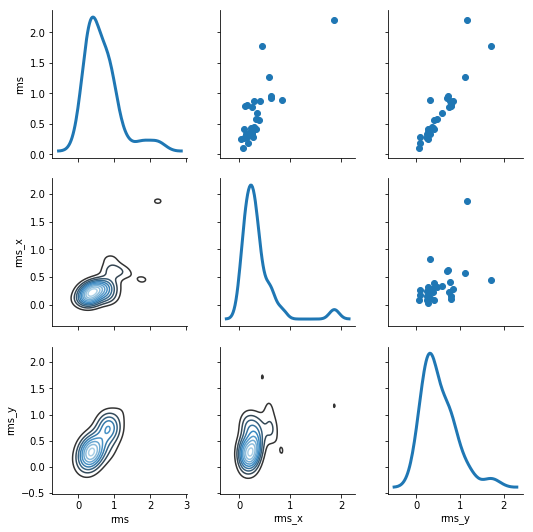

In [196]:
g = sns.PairGrid(analyses[["rms", "rms_x", "rms_y"]], diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

/home/masasin/.pyenv/versions/3.6.0/envs/scipy_stack/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


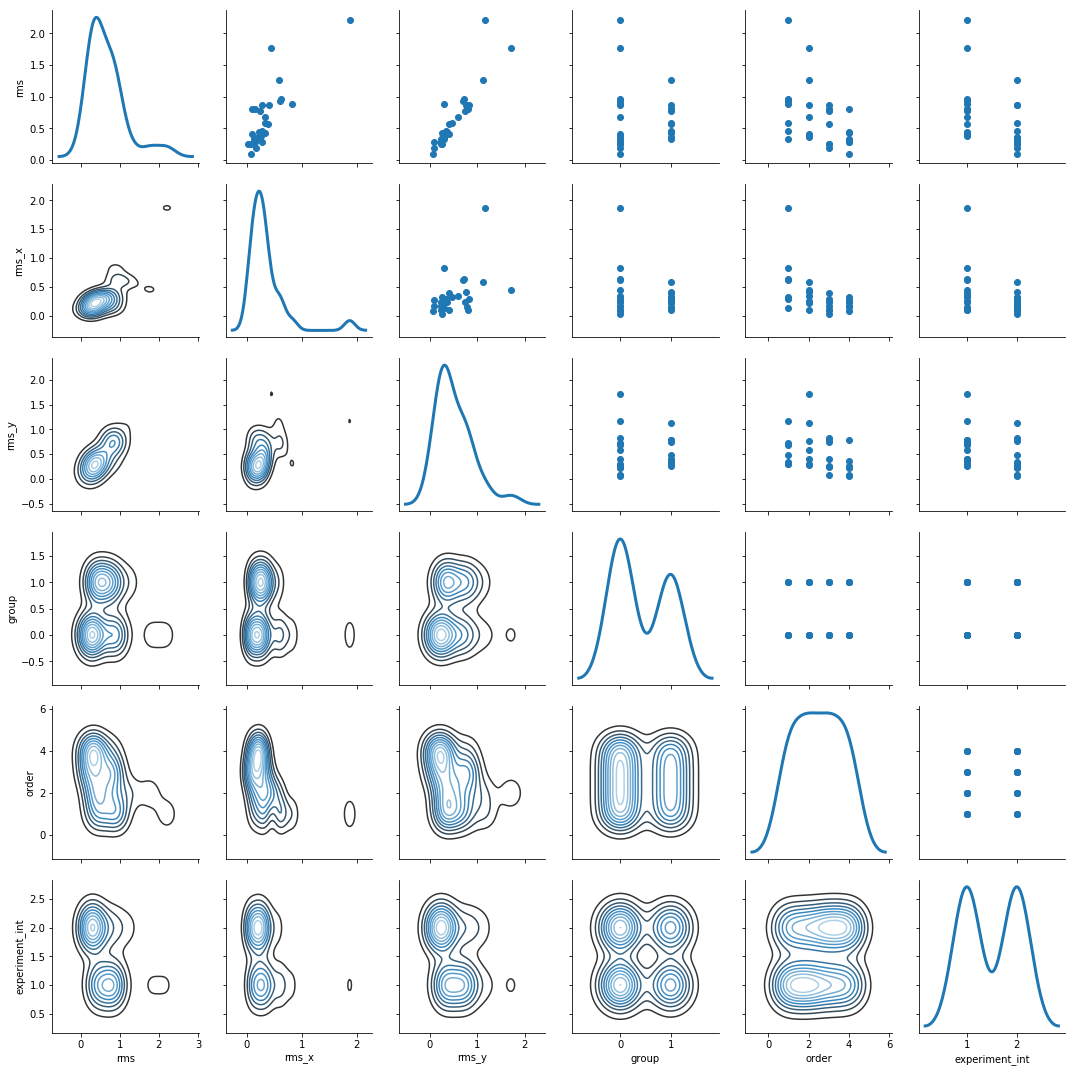

In [195]:
g = sns.PairGrid(analyses[["rms", "rms_x", "rms_y", "group", "order", "experiment_int"]], diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

/home/masasin/.pyenv/versions/3.6.0/envs/scipy_stack/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


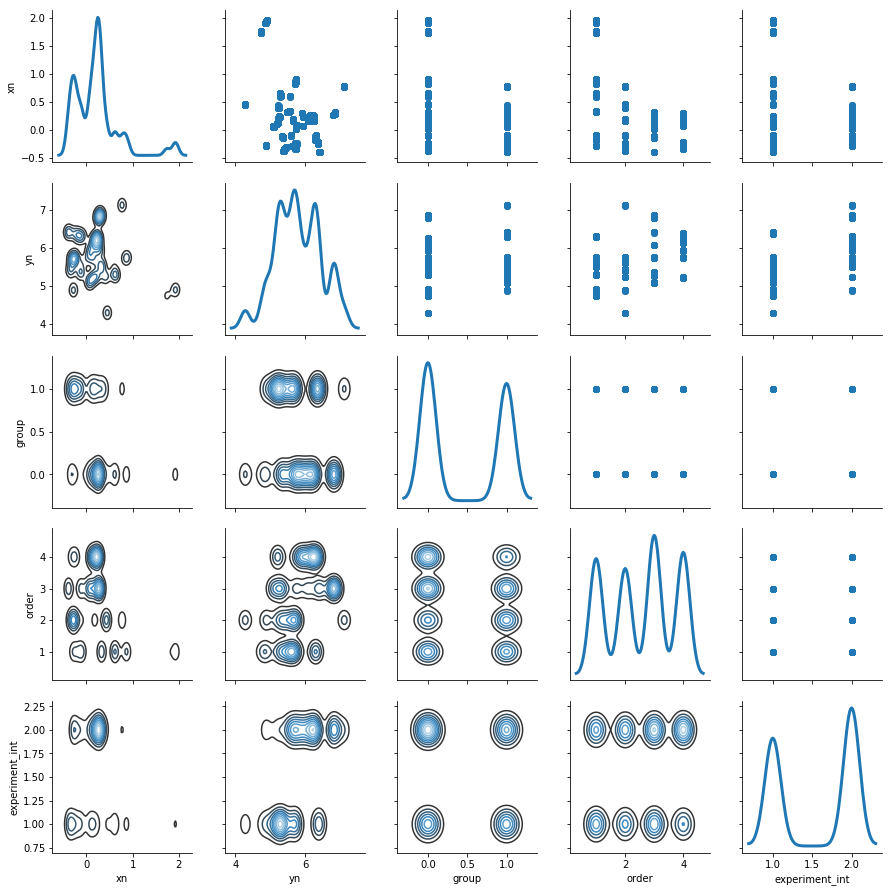

In [70]:
g = sns.PairGrid(results[results.arrived==1][["xn", "yn", "group", "order", "experiment_int"]], diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

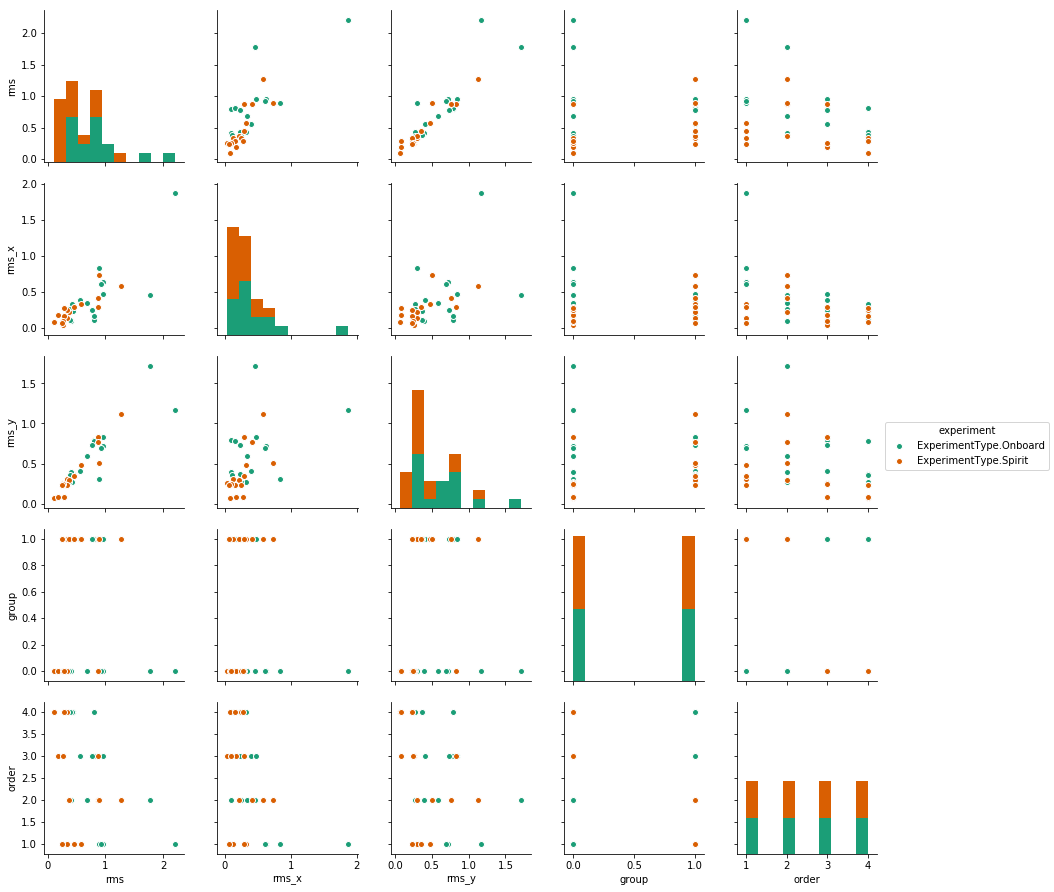

In [746]:
sns.pairplot(analyses[["rms", "rms_x", "rms_y", "group", "order", "experiment"]], hue="experiment")

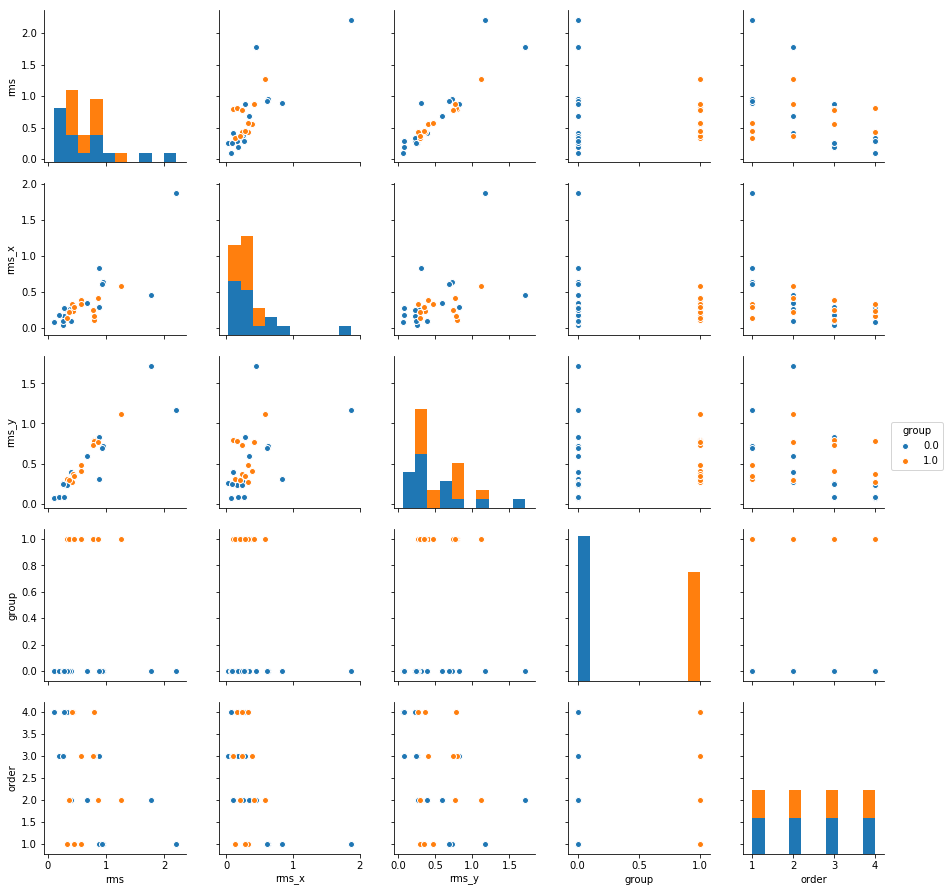

In [72]:
sns.pairplot(analyses[["rms", "rms_x", "rms_y", "group", "order", "experiment"]], hue="group")

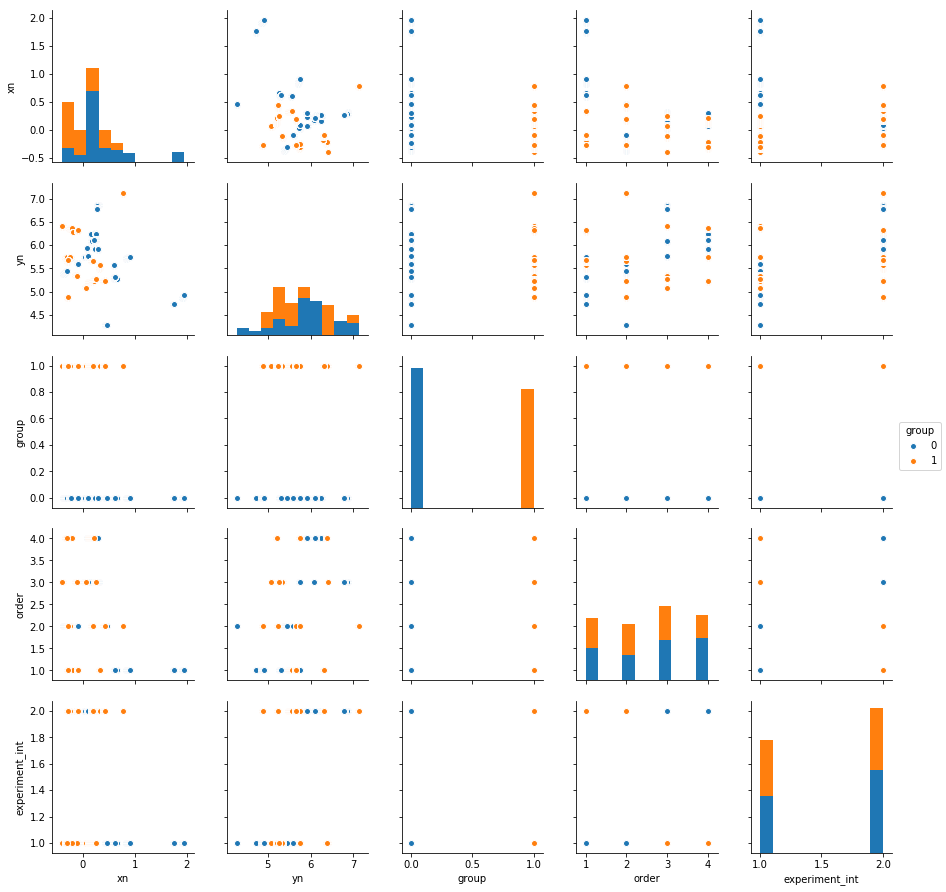

In [73]:
sns.pairplot(results[results.arrived==1][["xn", "yn", "group", "order", "experiment_int"]], hue="group")

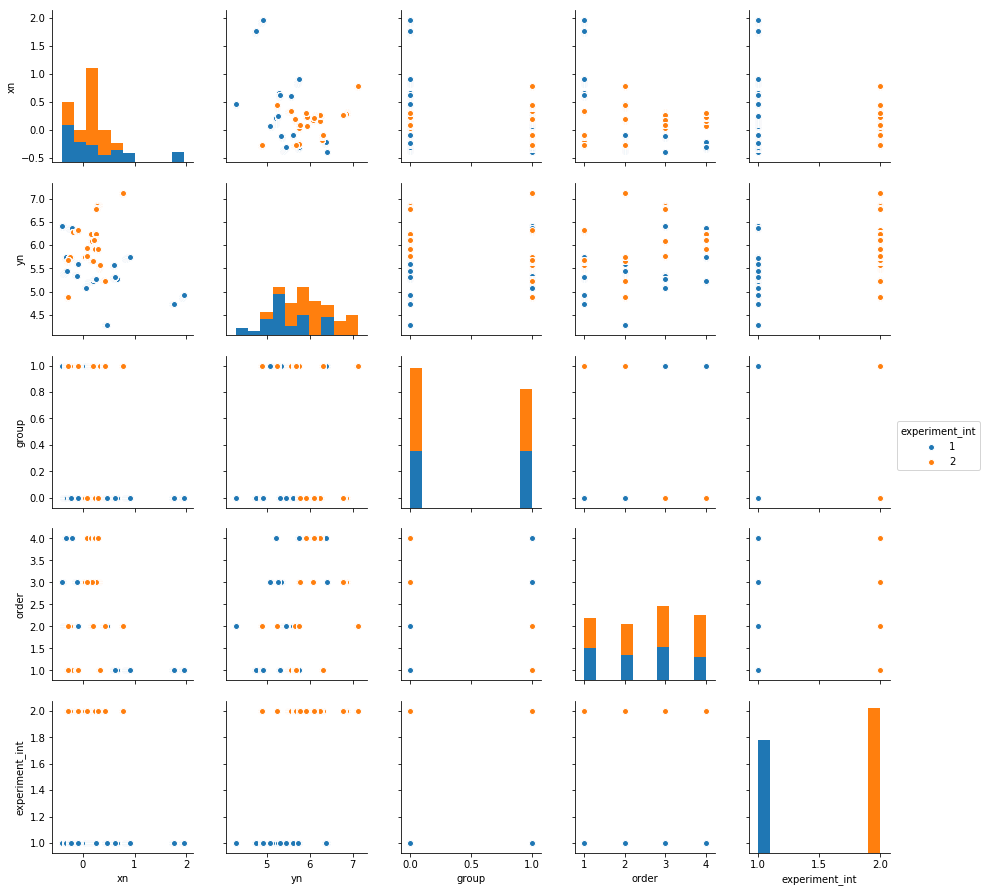

In [74]:
sns.pairplot(results[results.arrived==1][["xn", "yn", "group", "order", "experiment_int"]], hue="experiment_int")

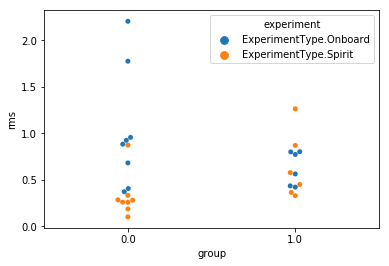

In [75]:
sns.swarmplot(x="group", y="rms", hue="experiment", data=analyses)

# SURVEYS!

In [25]:
import pickle

In [26]:
with open("data.pickle", "rb") as fin:
    data = pickle.load(fin)

In [27]:
users = pd.DataFrame({"user_id": user.id_, "name": user.name, "age": user.age,
                       "teleop": user.teleop, "flying": user.flying} for user in data)
users

age flying         name teleop  user_id
0  23      0     takemori      0        0
1  22      0    tsujimoto      0        1
2  22      0     yanagiya      0        2
3  29      0  sajid nisar     75        3
4  25      0         chen     10        4
5  24      0        kawai      0        5
6  24      0          wen      0        6
7  24      0      konishi      0        7

In [28]:
_tlx_data = []
for user in data:
    for experiment in user.experiments:
        d = {"user": user.id_, "experiment_type": experiment.type_}
        for component in experiment.tlx.components.values():
            parsed = parse_tlx_component(component)
            d[parsed.code] = parsed.score
        _tlx_data.append(d)
tlx = pd.DataFrame(_tlx_data)
tlx["group"] = tlx.user % 2
tlx["tlx"] = tlx.mental + tlx.physical + tlx.temporal + tlx.performance + tlx.effort + tlx.frustration
tlx["order"] = [1, 2]*(len(tlx)//2)
tlx["experiment_int"] = [e.value for e in tlx.experiment_type]
tlx["experiment"] = [e.name for e in tlx.experiment_type]
tlx.experiment.replace("Spirit", "SPIRIT", inplace=True)
tlx

effort         experiment_type  frustration  mental  performance  \
0       14  ExperimentType.Onboard           56      10           42   
1       18   ExperimentType.Spirit           30       8           16   
2        4   ExperimentType.Spirit           10      20           10   
3       15  ExperimentType.Onboard           12      16            6   
4       57  ExperimentType.Onboard           54      32           20   
5       33   ExperimentType.Spirit           45      28           30   
6        9   ExperimentType.Spirit            5      15           25   
7       16  ExperimentType.Onboard            0      15           20   
8       20  ExperimentType.Onboard           36      64           16   
9       20   ExperimentType.Spirit           30      60            6   
10      28   ExperimentType.Spirit           22      44           24   
11      32  ExperimentType.Onboard            5      32           14   
12      64  ExperimentType.Onboard            0      36           60   
13      27   ExperimentType.Spirit            5      14           15   
14      12   ExperimentType.Spirit            9      25            4   
15      52  ExperimentType.Onboard           36      30           27   

    physical  temporal  user  group  tlx  order  experiment_int experiment  
0          0        60     0      0  182      1               1    Onboard  
1          0         6     0      0   78      2               2     SPIRIT  
2          0         0     1      1   44      1               2     SPIRIT  
3          0         0     1      1   49      2               1    Onboard  
4          0        10     2      0  173      1               1    Onboard  
5          0         3     2      0  139      2               2     SPIRIT  
6          0         6     3      1   60      1               2     SPIRIT  
7          3         4     3      1   58      2               1    Onboard  
8          0         5     4      0  141      1               1    Onboard  
9          0         5     4      0  121      2               2     SPIRIT  
10         0         6     5      1  124      1               2     SPIRIT  
11         0        24     5      1  107      2               1    Onboard  
12        32        28     6      0  220      1               1    Onboard  
13         6        14     6      0   81      2               2     SPIRIT  
14         0         3     7      1   53      1               2     SPIRIT  
15         5         0     7      1  150      2               1    Onboard

In [29]:
_survey_data = []

for user in data:
    for experiment in user.experiments:
        d = {"user": user.id_, "experiment_type": experiment.type_}
        d.update({i.code:i.score for i in experiment.survey.questions.values()})
        _survey_data.append(d)

surveys = pd.DataFrame(_survey_data)
surveys["group"] = tlx.user % 2
surveys["order"] = [1, 2]*(len(surveys)//2)
surveys["experiment"] = [e.name for e in surveys.experiment_type]
surveys["experiment_int"] = [e.value for e in surveys.experiment_type]
surveys.experiment.replace("Spirit", "SPIRIT", inplace=True)
surveys

experiment_type  orientation_control  orientation_understanding  \
0   ExperimentType.Onboard                    5                          5   
1    ExperimentType.Spirit                    4                          4   
2    ExperimentType.Spirit                    4                          5   
3   ExperimentType.Onboard                    4                          4   
4   ExperimentType.Onboard                    2                          4   
5    ExperimentType.Spirit                    4                          5   
6    ExperimentType.Spirit                    3                          3   
7   ExperimentType.Onboard                    5                          5   
8   ExperimentType.Onboard                    6                          6   
9    ExperimentType.Spirit                    6                          6   
10   ExperimentType.Spirit                    5                          4   
11  ExperimentType.Onboard                    3                          3   
12  ExperimentType.Onboard                    2                          3   
13   ExperimentType.Spirit                    4                          4   
14   ExperimentType.Spirit                    6                          6   
15  ExperimentType.Onboard                    3                          2   

    position_control  position_understanding  spacial_control  \
0                  2                       2                1   
1                  6                       5                6   
2                  3                       5                4   
3                  2                       4                2   
4                  2                       2                1   
5                  3                       4                4   
6                  4                       4                6   
7                  5                       5                5   
8                  5                       5                4   
9                  6                       6                6   
10                 5                       4                3   
11                 4                       3                4   
12                 1                       2                1   
13                 5                       6                6   
14                 5                       5                5   
15                 4                       3                2   

    spacial_understanding  user  group  order experiment  experiment_int  
0                       2     0      0      1    Onboard               1  
1                       5     0      0      2     SPIRIT               2  
2                       6     1      1      1     SPIRIT               2  
3                       2     1      1      2    Onboard               1  
4                       1     2      0      1    Onboard               1  
5                       5     2      0      2     SPIRIT               2  
6                       5     3      1      1     SPIRIT               2  
7                       2     3      1      2    Onboard               1  
8                       3     4      0      1    Onboard               1  
9                       6     4      0      2     SPIRIT               2  
10                      3     5      1      1     SPIRIT               2  
11                      4     5      1      2    Onboard               1  
12                      1     6      0      1    Onboard               1  
13                      6     6      0      2     SPIRIT               2  
14                      4     7      1      1     SPIRIT               2  
15                      2     7      1      2    Onboard               1

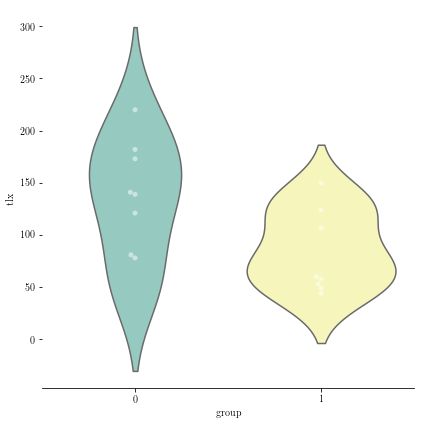

In [31]:
g = sns.factorplot(x="experiment", y="tlx", data=tlx,
                   size=6, kind="violin", split=True, inner=None)
sns.swarmplot(x="group", y="tlx", data=tlx, color="w", alpha=.5)
g.despine(left=True)

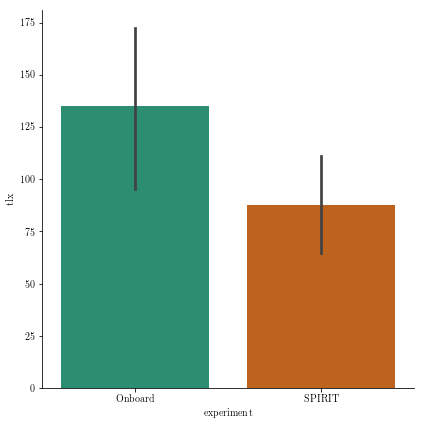

In [46]:
g = sns.factorplot(x="experiment", y="tlx", data=tlx,
                   size=6, kind="bar")

(0, 228.80000000000001)

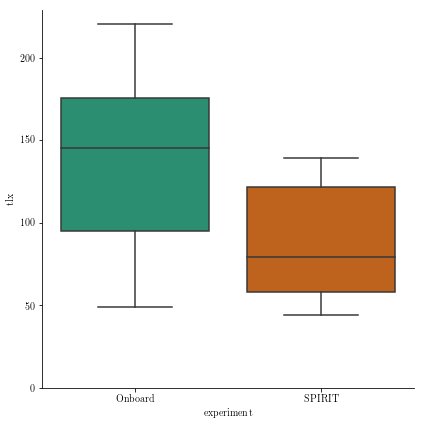

In [47]:
g = sns.factorplot(x="experiment", y="tlx", data=tlx,
                   size=6, kind="box")
plt.ylim(0, plt.ylim()[1])

In [48]:
g = sns.factorplot(x="variable", y="value", hue="experiment",
                   data=pd.melt(tlx, id_vars=["user", "experiment", "group", "tlx", "order"]),
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

TypeError: float() argument must be a string or a number, not 'ExperimentType'

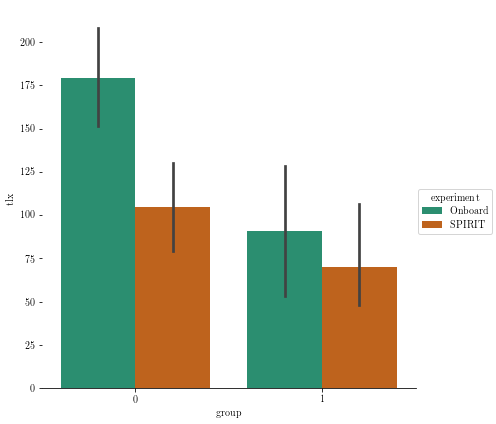

In [49]:
g = sns.factorplot(x="group", y="tlx", hue="experiment", data=tlx,
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

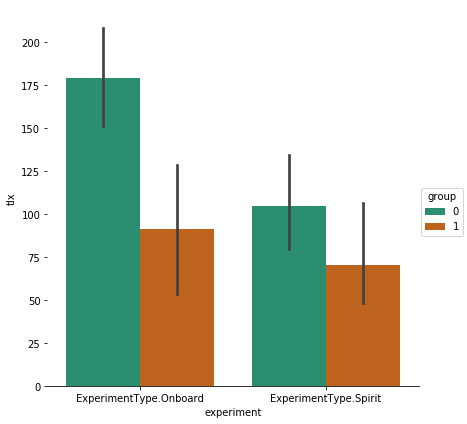

In [97]:
g = sns.factorplot(x="experiment", y="tlx", hue="group", data=tlx,
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

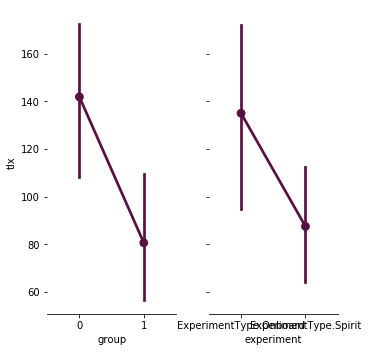

In [98]:
g = sns.PairGrid(tlx, y_vars="tlx",
                 x_vars=["group", "experiment"],
                 size=5, aspect=.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
sns.despine(fig=g.fig, left=True)

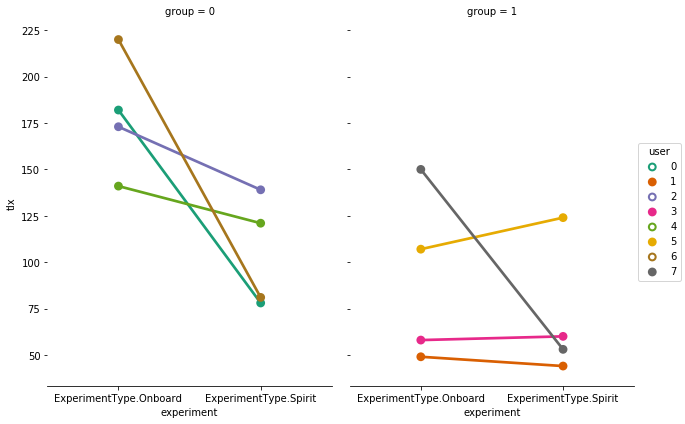

In [99]:
g = sns.factorplot(x="experiment", y="tlx", col="group", hue="user", data=tlx,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

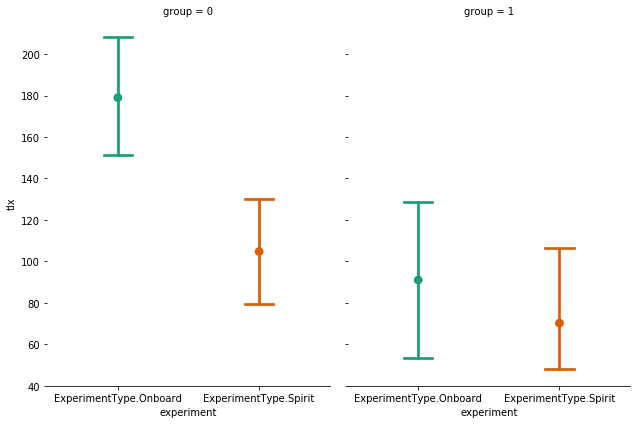

In [100]:
g = sns.factorplot(x="experiment", y="tlx", col="group", data=tlx,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

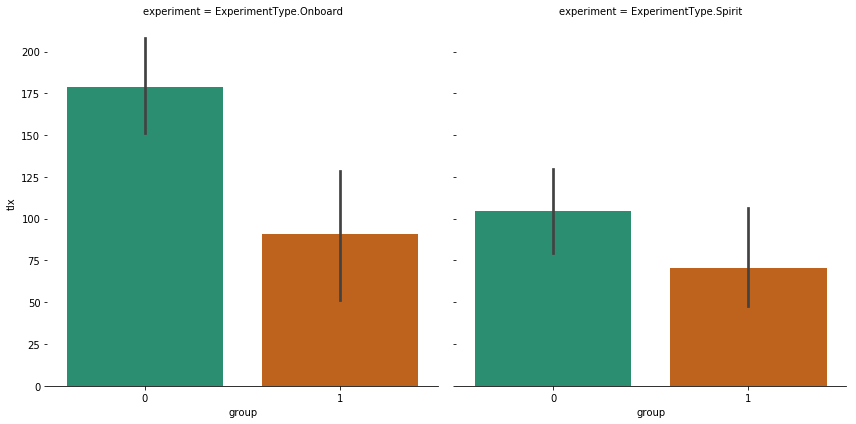

In [101]:
g = sns.factorplot(x="group", y="tlx", col="experiment", data=tlx,
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

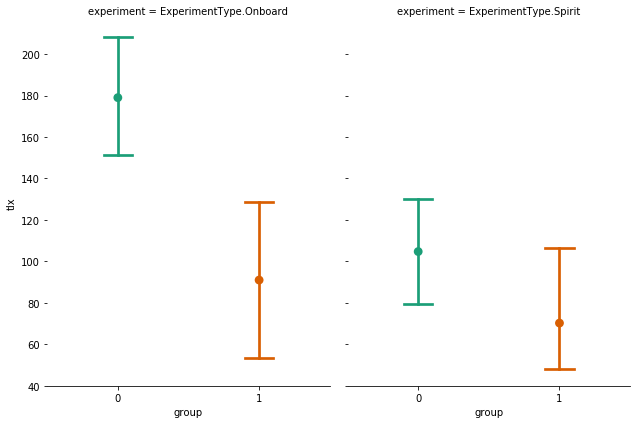

In [102]:
g = sns.factorplot(x="group", y="tlx", col="experiment", data=tlx,
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

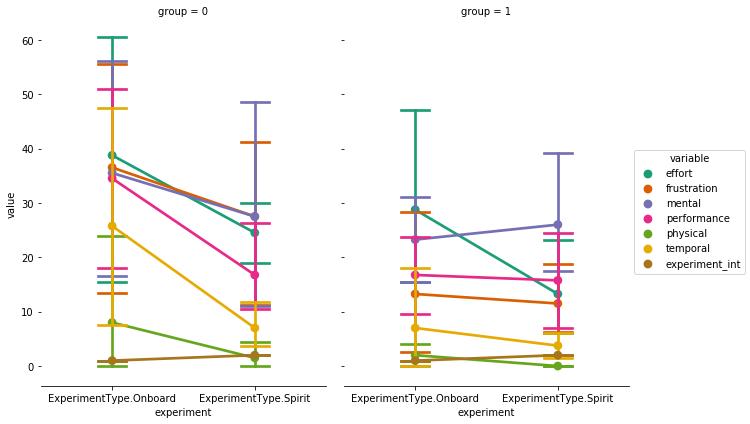

In [103]:
g = sns.factorplot(x="experiment", y="value", col="group", hue="variable",
                   data=pd.melt(tlx, id_vars=["user", "experiment", "group", "tlx", "order"]),
                   capsize=.2, palette="Dark2", size=6, aspect=.75)
g.despine(left=True)

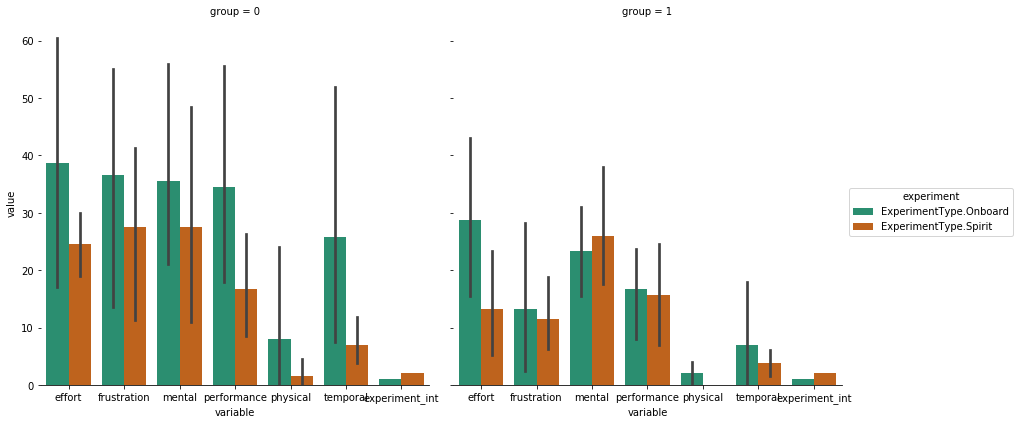

In [104]:
g = sns.factorplot(x="variable", y="value", hue="experiment", col="group",
                   data=pd.melt(tlx, id_vars=["user", "experiment", "group", "tlx", "order"]),
                   size=6, kind="bar", palette="Dark2")
g.despine(left=True)

In [105]:
surveys

experiment  orientation_control  orientation_understanding  \
0   ExperimentType.Onboard                    5                          5   
1    ExperimentType.Spirit                    4                          4   
2    ExperimentType.Spirit                    4                          5   
3   ExperimentType.Onboard                    4                          4   
4   ExperimentType.Onboard                    2                          4   
5    ExperimentType.Spirit                    4                          5   
6    ExperimentType.Spirit                    3                          3   
7   ExperimentType.Onboard                    5                          5   
8   ExperimentType.Onboard                    6                          6   
9    ExperimentType.Spirit                    6                          6   
10   ExperimentType.Spirit                    5                          4   
11  ExperimentType.Onboard                    3                          3   
12  ExperimentType.Onboard                    2                          3   
13   ExperimentType.Spirit                    4                          4   
14   ExperimentType.Spirit                    6                          6   
15  ExperimentType.Onboard                    3                          2   

    position_control  position_understanding  spacial_control  \
0                  2                       2                1   
1                  6                       5                6   
2                  3                       5                4   
3                  2                       4                2   
4                  2                       2                1   
5                  3                       4                4   
6                  4                       4                6   
7                  5                       5                5   
8                  5                       5                4   
9                  6                       6                6   
10                 5                       4                3   
11                 4                       3                4   
12                 1                       2                1   
13                 5                       6                6   
14                 5                       5                5   
15                 4                       3                2   

    spacial_understanding  user  group  order  
0                       2     0      0      1  
1                       5     0      0      2  
2                       6     1      1      1  
3                       2     1      1      2  
4                       1     2      0      1  
5                       5     2      0      2  
6                       5     3      1      1  
7                       2     3      1      2  
8                       3     4      0      1  
9                       6     4      0      2  
10                      3     5      1      1  
11                      4     5      1      2  
12                      1     6      0      1  
13                      6     6      0      2  
14                      4     7      1      1  
15                      2     7      1      2

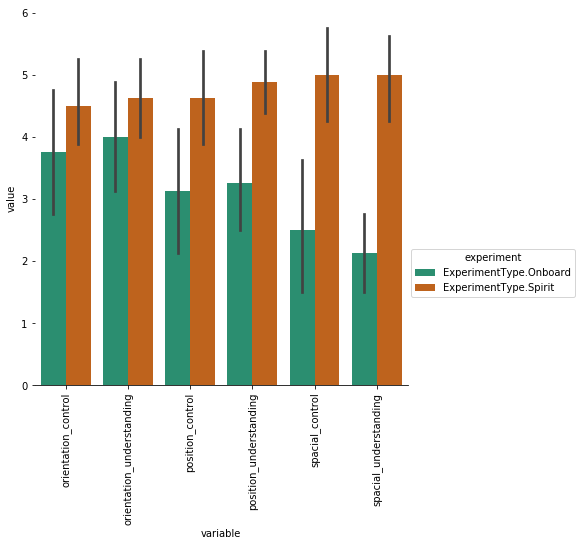

In [106]:
g = sns.factorplot(x="variable", y="value", hue="experiment",
                   data=pd.melt(surveys, id_vars=["user", "experiment", "group", "order"]),
                   size=6, kind="bar", palette="Dark2")
g.set_xticklabels(rotation=90)
g.despine(left=True)

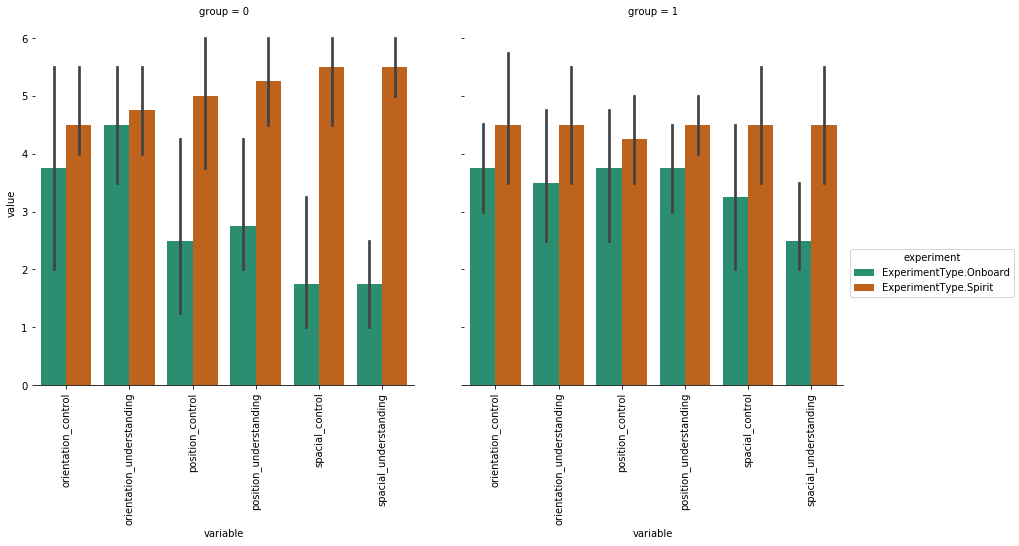

In [107]:
g = sns.factorplot(x="variable", y="value", hue="experiment", col="group",
                   data=pd.melt(surveys, id_vars=["user", "experiment", "group", "order"]),
                   size=6, kind="bar", palette="Dark2")
g.set_xticklabels(rotation=90)
g.despine(left=True)

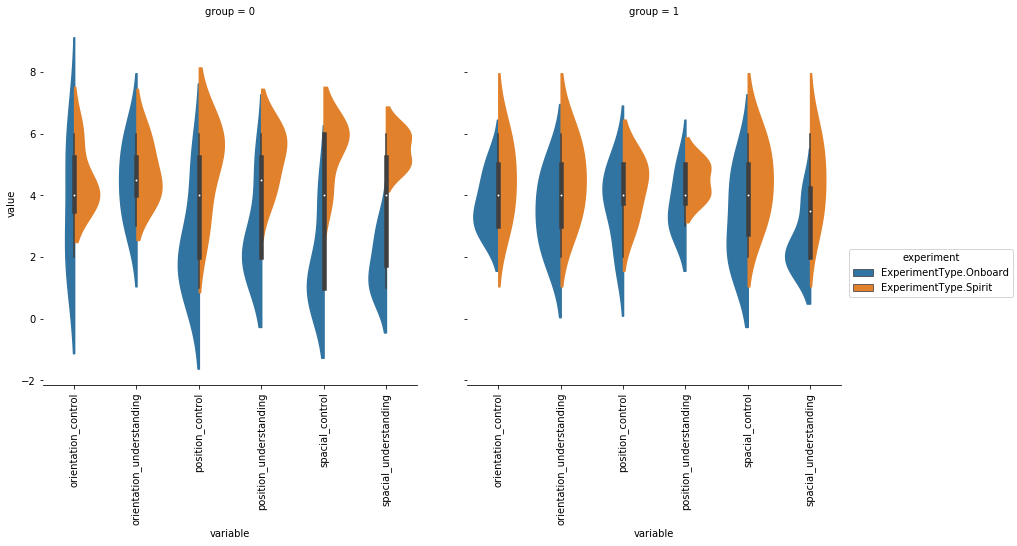

In [108]:
g = sns.factorplot(x="variable", y="value", hue="experiment", col="group",
                   data=pd.melt(surveys, id_vars=["user", "experiment", "group", "order"]),
                   size=6, kind="violin", split=True)

g.set_xticklabels(rotation=90)
g.despine(left=True)

# PyMC3

Assigned NUTS to group1_mean
Assigned NUTS to group2_mean
Assigned NUTS to group1_std_interval_
Assigned NUTS to group2_std_interval_
Assigned NUTS to ν_minus_one_log_
100%|██████████| 2000/2000 [00:20<00:00, 98.52it/s] 



difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.366            0.114            0.003            [0.138, 0.587]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.127          0.295          0.370          0.441          0.581


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.095            0.108            0.003            [-0.115, 0.316]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.112         0.025          0.091          0.158          0.321


effect size:

  Mean             SD               MC Error         95% HPD in

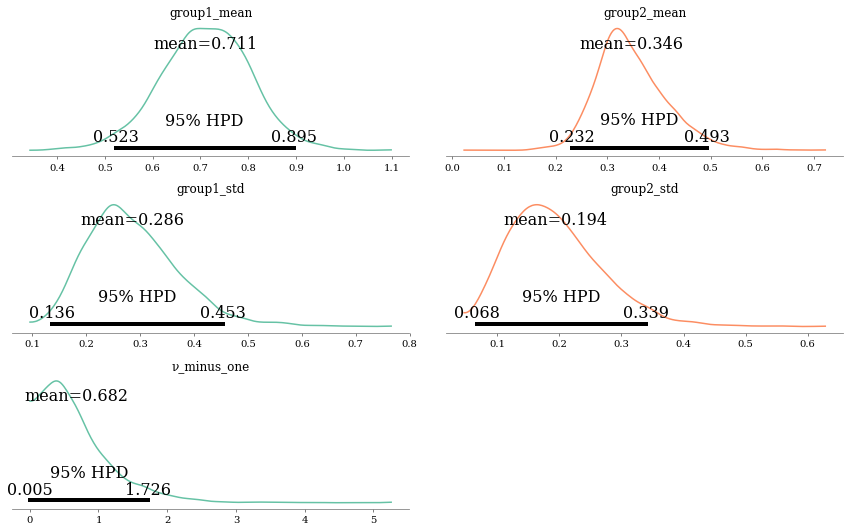

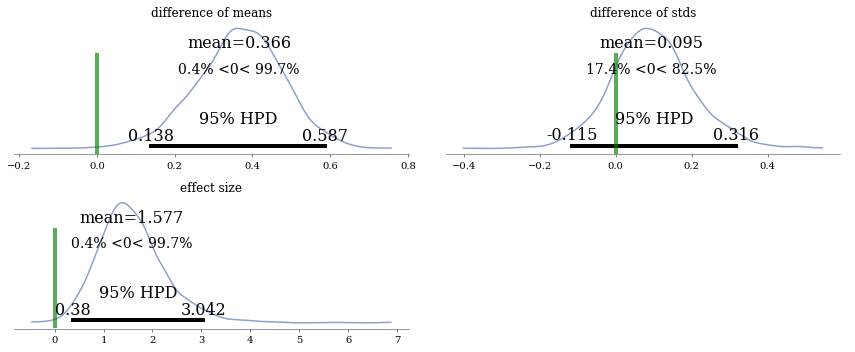

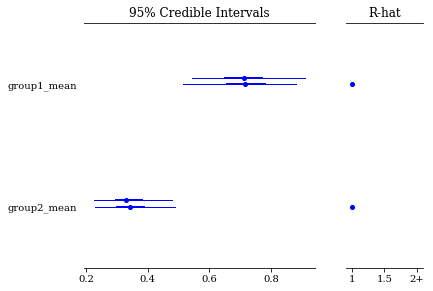

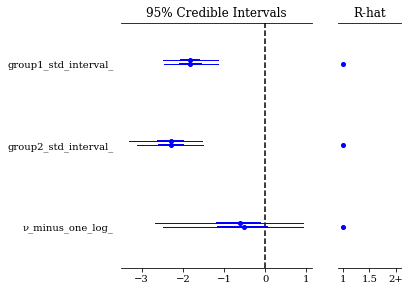

In [203]:
sample1 = analyses[analyses.experiment_type==ExperimentType.Onboard].dist_err
sample2 = analyses[analyses.experiment_type==ExperimentType.Spirit].dist_err
trace_dist = bestest(sample1, sample2, (0, 2), 0.5)
summarize(trace_dist)

Assigned NUTS to group1_mean
Assigned NUTS to group2_mean
Assigned NUTS to group1_std_interval_
Assigned NUTS to group2_std_interval_
Assigned NUTS to ν_minus_one_log_
100%|██████████| 2000/2000 [00:19<00:00, 104.12it/s]



difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.038           0.153            0.004            [-0.345, 0.261]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.342         -0.138         -0.039         0.063          0.275


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.257            0.130            0.004            [0.003, 0.503]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.041          0.169          0.242          0.327          0.544


effect size:

  Mean             SD               MC Error         95% HPD in

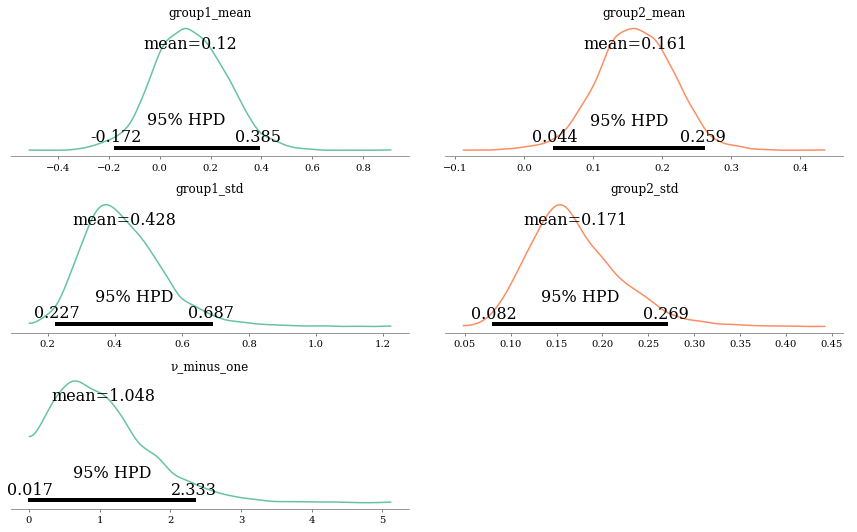

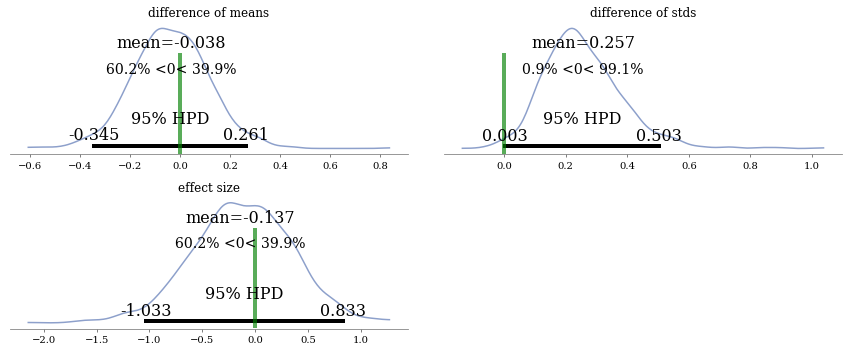

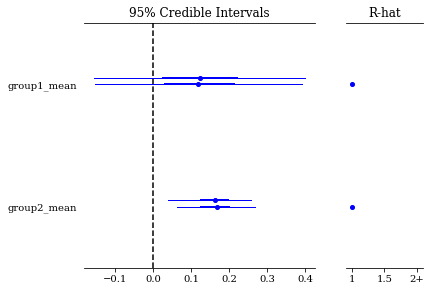

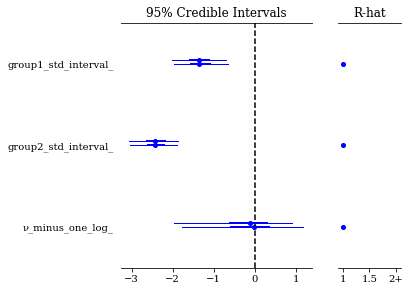

In [204]:
sample1 = analyses[analyses.experiment_type==ExperimentType.Onboard].x_err
sample2 = analyses[analyses.experiment_type==ExperimentType.Spirit].x_err
trace_x = bestest(sample1, sample2, (0, 2), 0.5)
summarize(trace_x)

Assigned NUTS to group1_mean
Assigned NUTS to group2_mean
Assigned NUTS to group1_std_interval_
Assigned NUTS to group2_std_interval_
Assigned NUTS to ν_minus_one_log_
100%|██████████| 2000/2000 [00:24<00:00, 82.75it/s] 



difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.477           0.169            0.005            [-0.813, -0.170]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.798         -0.592         -0.478         -0.365         -0.137


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.111            0.164            0.004            [-0.226, 0.427]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.201         0.010          0.103          0.211          0.459


effect size:

  Mean             SD               MC Error         95% HPD

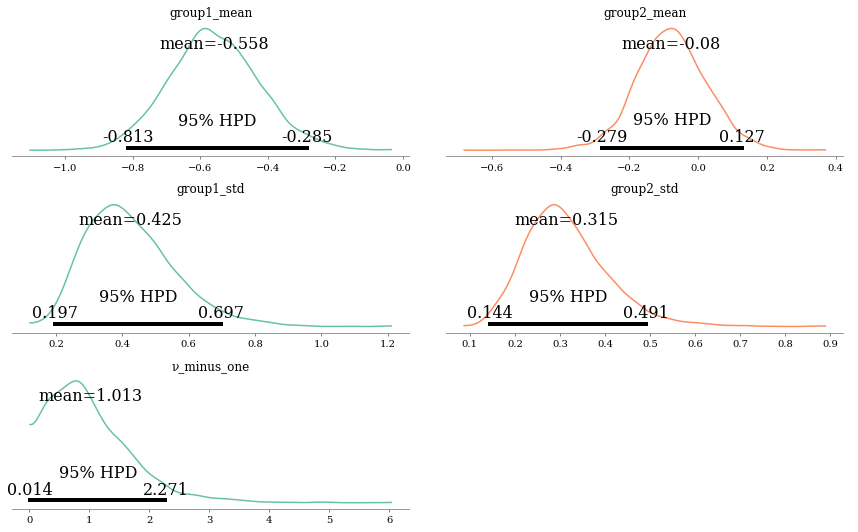

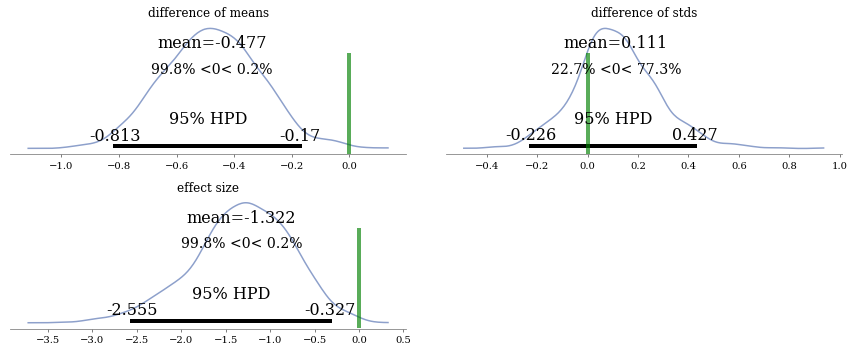

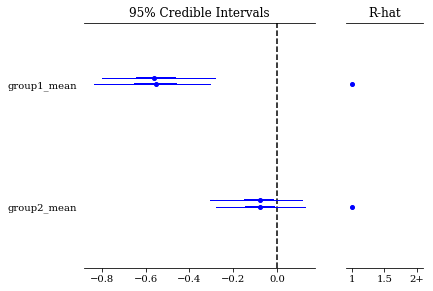

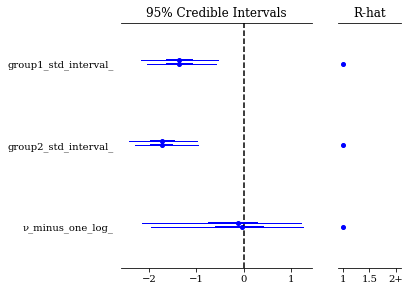

In [205]:
sample1 = analyses[analyses.experiment_type==ExperimentType.Onboard].y_err
sample2 = analyses[analyses.experiment_type==ExperimentType.Spirit].y_err
trace_y = bestest(sample1, sample2, (0, 2), 0.5)
summarize(trace_y)

Assigned NUTS to group1_mean
Assigned NUTS to group2_mean
Assigned NUTS to group1_std_interval_
Assigned NUTS to group2_std_interval_
Assigned NUTS to ν_minus_one_log_
100%|██████████| 2000/2000 [00:18<00:00, 108.00it/s]



difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.109            0.076            0.002            [-0.040, 0.252]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.036         0.058          0.111          0.156          0.258


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.071            0.073            0.002            [-0.066, 0.219]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.064         0.024          0.066          0.114          0.225


effect size:

  Mean             SD               MC Error         95% HPD i

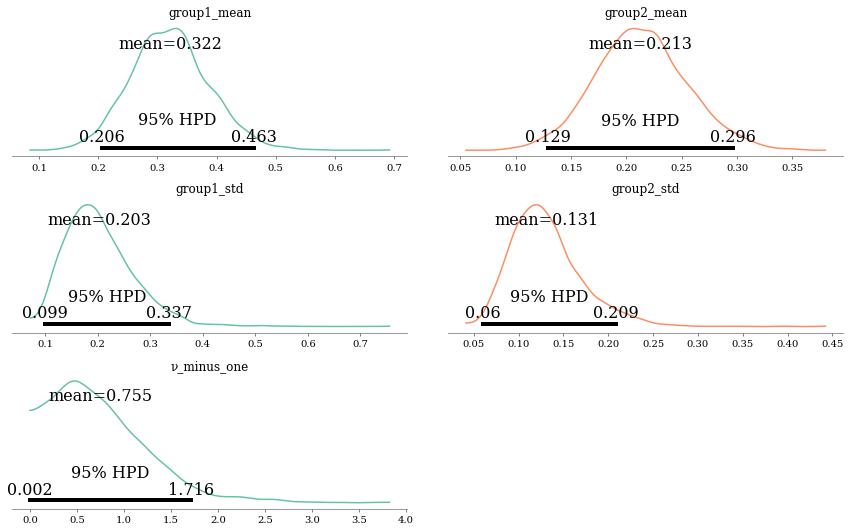

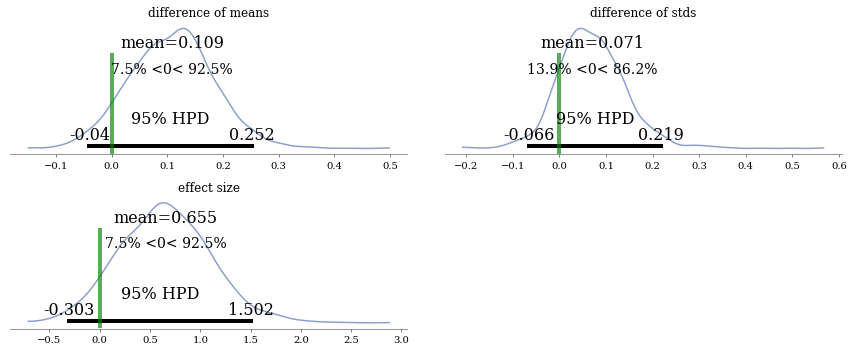

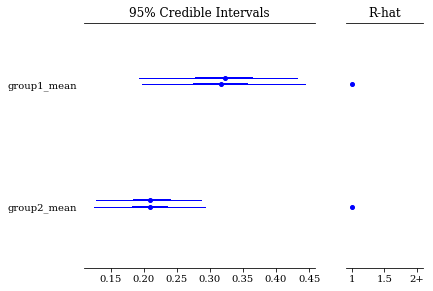

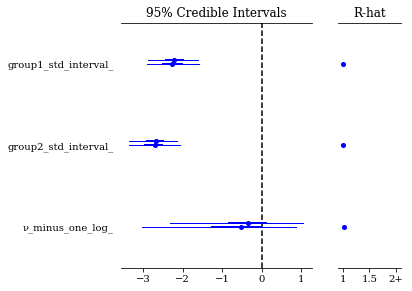

In [206]:
sample1 = analyses[analyses.experiment_type==ExperimentType.Onboard].rms_x
sample2 = analyses[analyses.experiment_type==ExperimentType.Spirit].rms_x
trace_rmsx = bestest(sample1, sample2, (0, 2), 0.5)
summarize(trace_rmsx)

Assigned NUTS to group1_mean
Assigned NUTS to group2_mean
Assigned NUTS to group1_std_interval_
Assigned NUTS to group2_std_interval_
Assigned NUTS to ν_minus_one_log_
100%|██████████| 2000/2000 [00:18<00:00, 106.81it/s]



difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.284            0.107            0.003            [0.081, 0.492]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.062          0.213          0.288          0.358          0.482


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.090            0.098            0.003            [-0.117, 0.278]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.102         0.029          0.088          0.149          0.300


effect size:

  Mean             SD               MC Error         95% HPD in

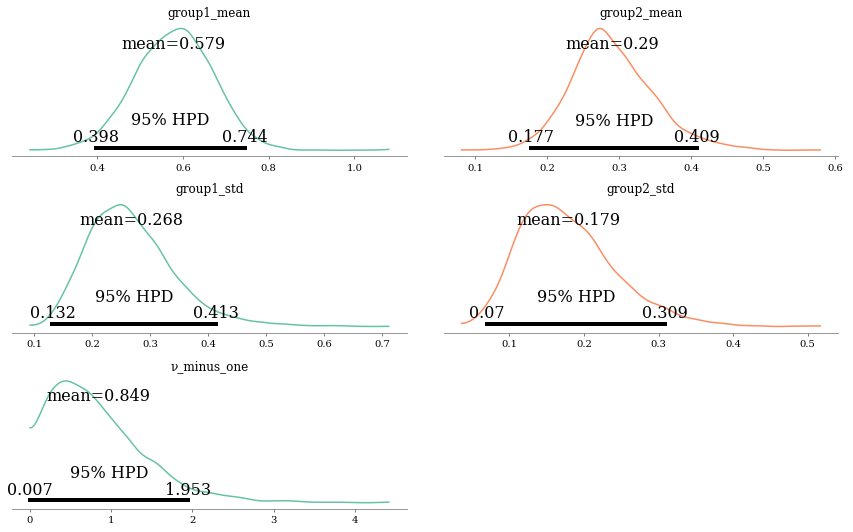

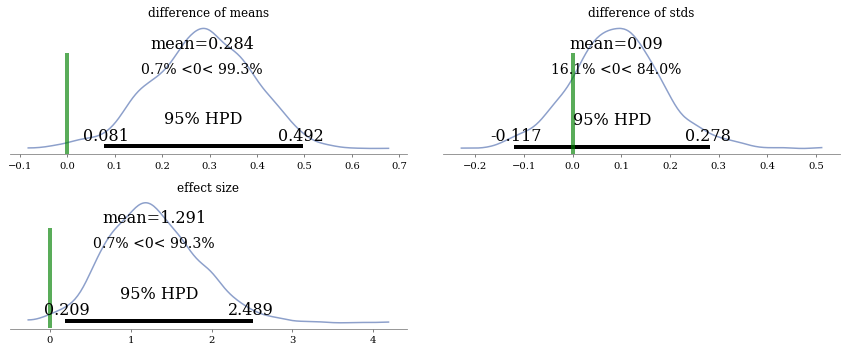

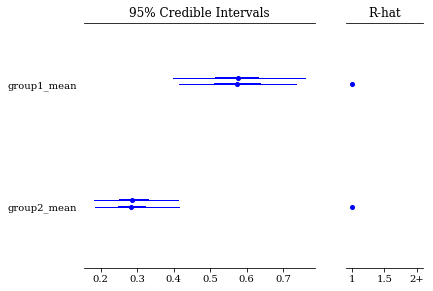

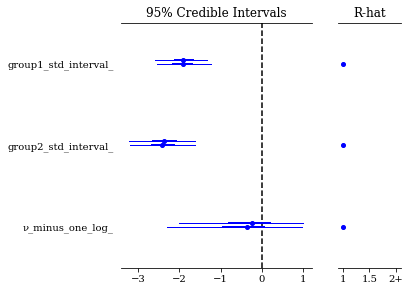

In [207]:
sample1 = analyses[analyses.experiment_type==ExperimentType.Onboard].rms_y
sample2 = analyses[analyses.experiment_type==ExperimentType.Spirit].rms_y
trace_rmsy = bestest(sample1, sample2, (0, 2), 0.5)
summarize(trace_rmsy)

Assigned NUTS to group1_mean
Assigned NUTS to group2_mean
Assigned NUTS to group1_std_interval_
Assigned NUTS to group2_std_interval_
Assigned NUTS to ν_minus_one_log_
100%|██████████| 2000/2000 [01:15<00:00, 26.41it/s]



difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -5.773           6.106            0.199            [-16.956, 7.198]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -17.556        -9.920         -5.986         -1.770         6.919


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.155            5.431            0.204            [-5.197, 15.849]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -4.606         1.659          4.775          8.278          16.954


effect size:

  Mean             SD               MC Error         95% HP

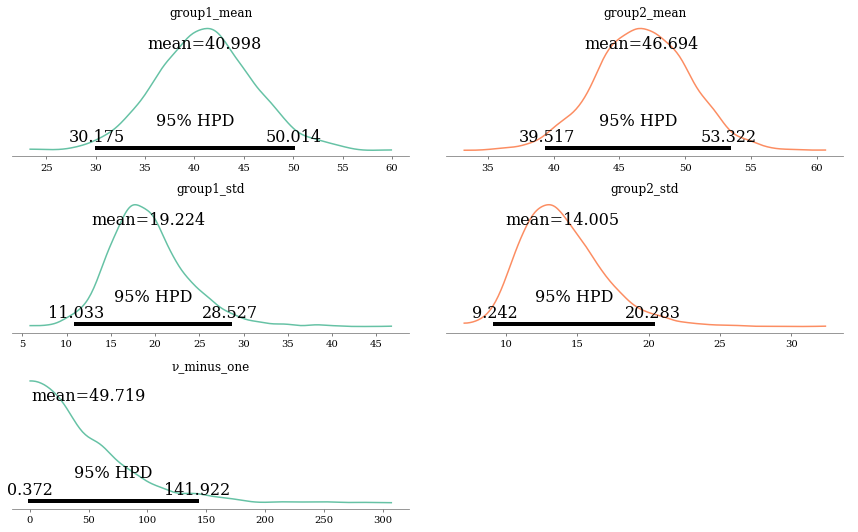

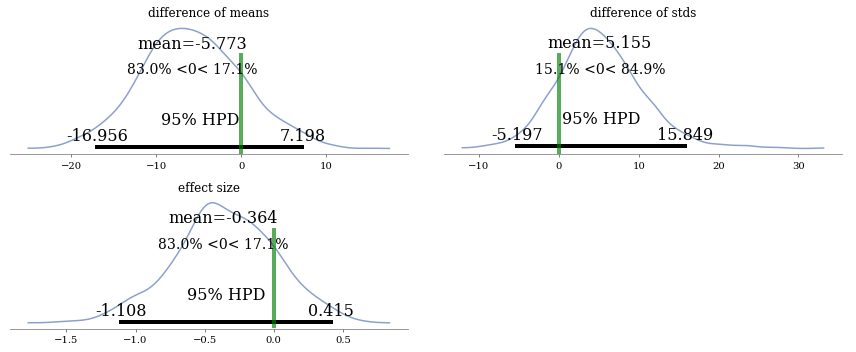

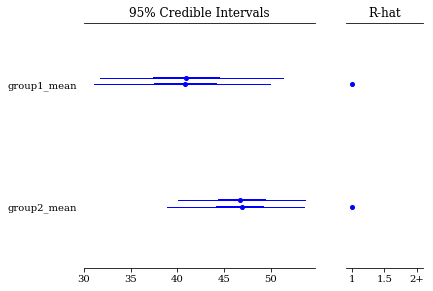

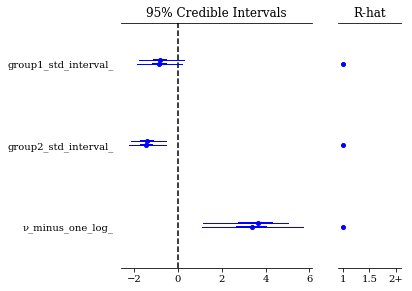

In [208]:
sample1 = analyses[analyses.experiment_type==ExperimentType.Onboard].duration
sample2 = analyses[analyses.experiment_type==ExperimentType.Spirit].duration
trace_dur = bestest(sample1, sample2, (5, 50), 50)
summarize(trace_dur)

# Graphs

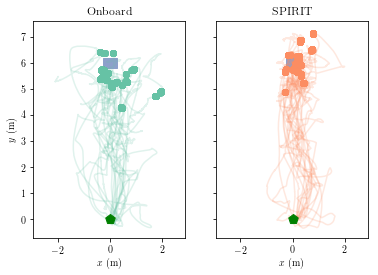

In [54]:
ax1 = plt.subplot("121")
plot_overview(results, ExperimentType.Onboard, color="C0")
ax2 = plt.subplot("122", sharex=ax1, sharey=ax1)
plot_overview(results, ExperimentType.Spirit, color="C1", ylabel="")
plt.setp(ax2.get_yticklabels(), visible=False);

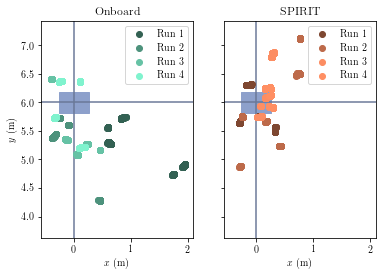

In [55]:
ax1 = plt.subplot("121")
plot_detailed(results, ExperimentType.Onboard, color="C0", crosshair=True)
ax2 = plt.subplot("122", sharex=ax1, sharey=ax1)
plot_detailed(results, ExperimentType.Spirit, color="C1", crosshair=True, ylabel="")
plt.ylim(3.75, ax2.get_ylim()[1])
plt.setp(ax2.get_yticklabels(), visible=False);

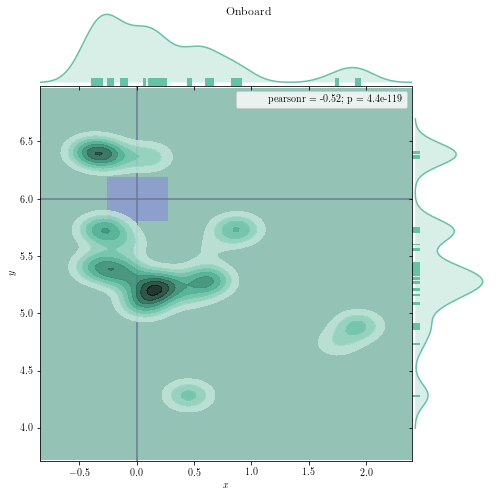

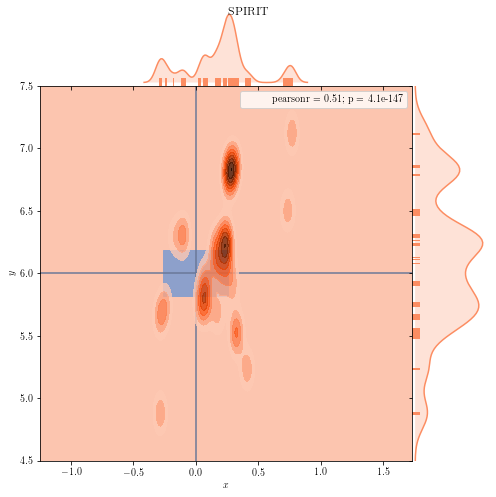

In [155]:
plot_distribution(results, ExperimentType.Onboard, color="C0", crosshair=True)
plot_distribution(results, ExperimentType.Spirit, color="C1", crosshair=True)

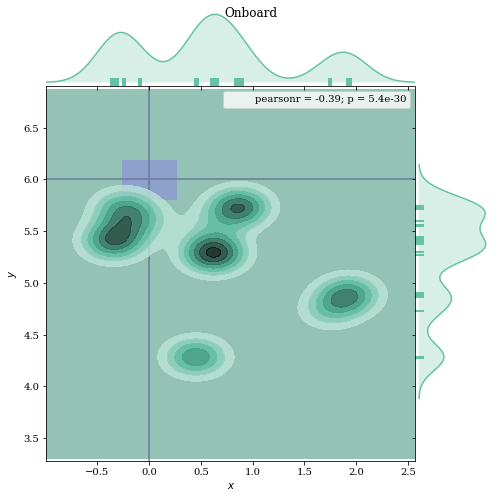

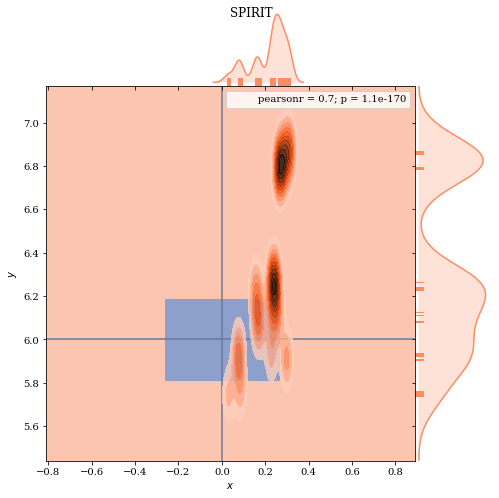

In [251]:
plot_distribution(results[results.group==0], ExperimentType.Onboard, color="C0", crosshair=True)
plot_distribution(results[results.group==0], ExperimentType.Spirit, color="C1", crosshair=True)

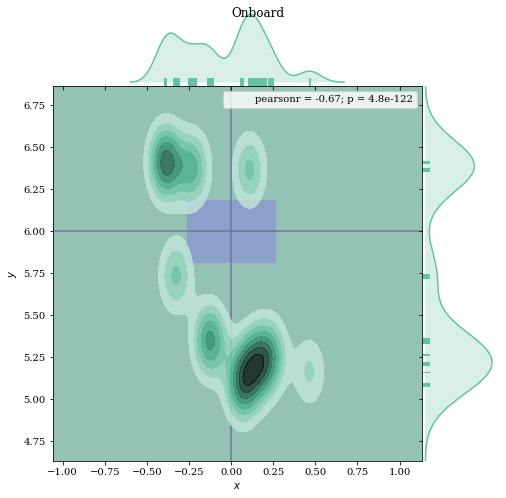

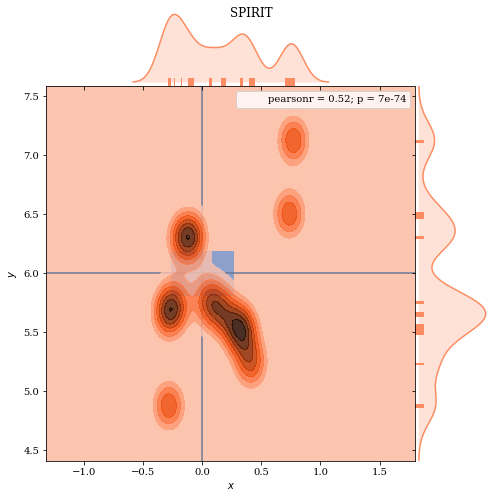

In [252]:
plot_distribution(results[results.group==1], ExperimentType.Onboard, color="C0", crosshair=True)
plot_distribution(results[results.group==1], ExperimentType.Spirit, color="C1", crosshair=True)

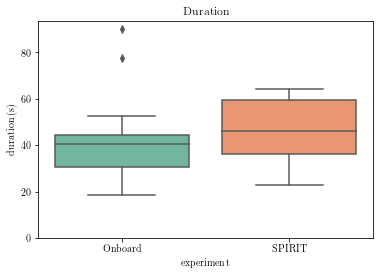

In [156]:
g = sns.boxplot(x="experiment", y="duration", data=analyses)
plt.ylim(0, plt.ylim()[1])
plt.ylabel("duration (s)")
plt.title("Duration")

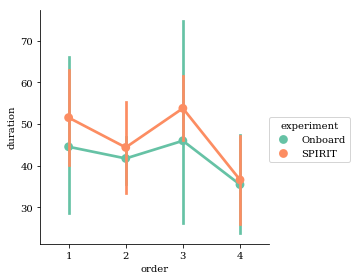

In [233]:
g = sns.factorplot(x="order", y="duration", hue="experiment", data=analyses)

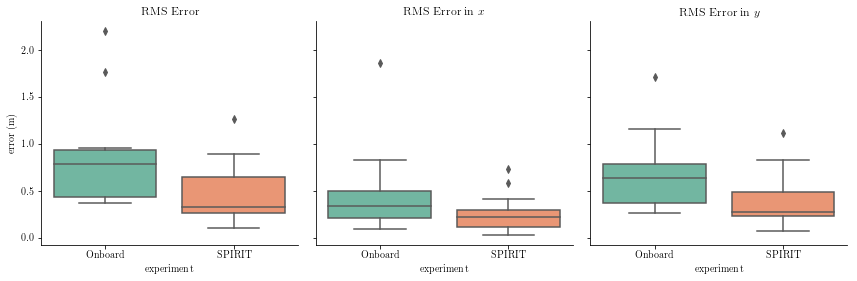

In [157]:
g = sns.factorplot(x="experiment", y="value", col="variable",
                   data=pd.melt(analyses, id_vars=["user", "experiment", "order", "group"],
                                value_vars=["rms", "rms_x", "rms_y"]),
                   kind="box", size=4)
g.fig.axes[0].set_title("RMS Error")
g.fig.axes[1].set_title("RMS Error in $x$")
g.fig.axes[2].set_title("RMS Error in $y$")
g.fig.axes[0].set_ylabel("error (m)")

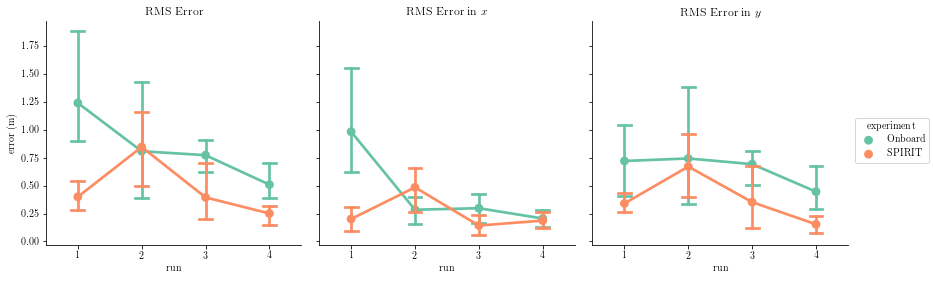

In [158]:
g = sns.factorplot(x="order", y="value", hue="experiment", col="variable",
                   data=pd.melt(analyses, id_vars=["user", "experiment", "order", "group"],
                                value_vars=["rms", "rms_x", "rms_y"]),
                   capsize=0.2)
g.fig.axes[0].set_title("RMS Error")
g.fig.axes[1].set_title("RMS Error in $x$")
g.fig.axes[2].set_title("RMS Error in $y$")
g.fig.axes[0].set_ylabel("error (m)")
g.fig.axes[0].set_xlabel("run")
g.fig.axes[1].set_xlabel("run")
g.fig.axes[2].set_xlabel("run")

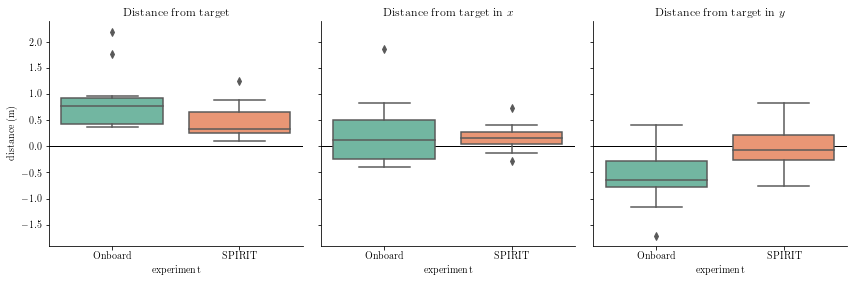

In [159]:
g = sns.factorplot(x="experiment", y="value", col="variable",
                   data=pd.melt(analyses, id_vars=["user", "experiment", "order", "group"],
                                value_vars=[r"dist_err", r"x_err", r"y_err"]),
                   size=4, kind="box")
g.fig.axes[0].set_title("Distance from target")
g.fig.axes[1].set_title("Distance from target in $x$")
g.fig.axes[2].set_title("Distance from target in $y$")
g.fig.axes[0].set_ylabel("distance (m)")
g.axes[0][0].axhline(0, color="black", linewidth=1, zorder=-1)
g.axes[0][1].axhline(0, color="black", linewidth=1, zorder=-1)
g.axes[0][2].axhline(0, color="black", linewidth=1, zorder=-1)

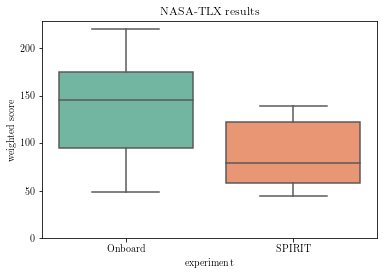

In [160]:
g = sns.boxplot(x="experiment", y="tlx", data=tlx)
plt.ylim(0, plt.ylim()[1])
plt.title("NASA-TLX results")
plt.ylabel("weighted score")

(0, 228.80000000000001)

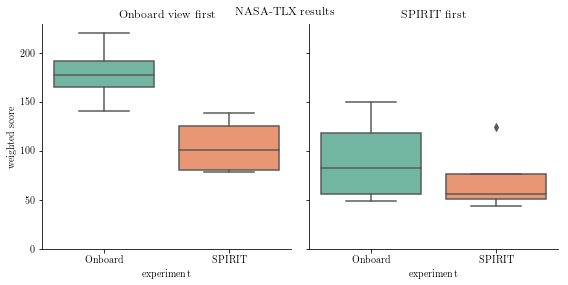

In [161]:
g = sns.factorplot(x="experiment", y="tlx", col="group", data=tlx, kind="box")
g.fig.axes[0].set_title("Onboard view first")
g.fig.axes[1].set_title("SPIRIT first")
g.fig.axes[0].set_ylabel("weighted score")
plt.suptitle(r"NASA-TLX results")
plt.ylim(0, plt.ylim()[1])

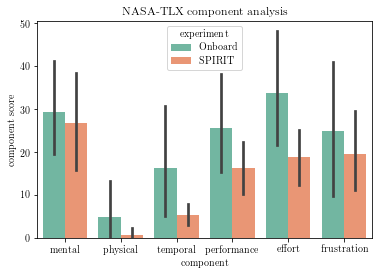

In [162]:
g = sns.barplot(x=r"component", y="score", hue="experiment",
                   data=pd.melt(tlx, id_vars=["user", "experiment", "order"],
                                value_vars=["mental", "physical", "temporal",
                                            "performance", "effort", "frustration"],
                                var_name="component", value_name="score"))
plt.ylabel("component score")
plt.title("NASA-TLX component analysis")

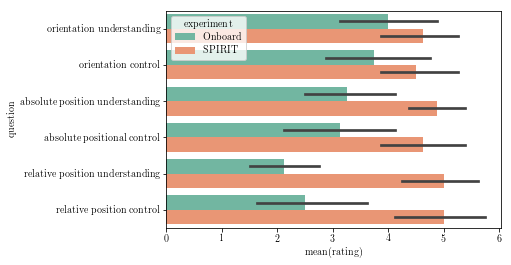

In [163]:
g = sns.barplot(x=r"rating", y=r"question", hue="experiment",
                   data=pd.melt(surveys, id_vars=["user", "experiment", "order"],
                               value_vars=[r"orientation_understanding", r"orientation_control",
                                           r"position_understanding", r"position_control",
                                           r"spacial_understanding", r"spacial_control"],
                               var_name="question", value_name="rating"))
plt.gca().set_yticklabels(["orientation understanding", "orientation control",
                           "absolute position understanding", "absolute positional control",
                           "relative position understanding", "relative position control"]);

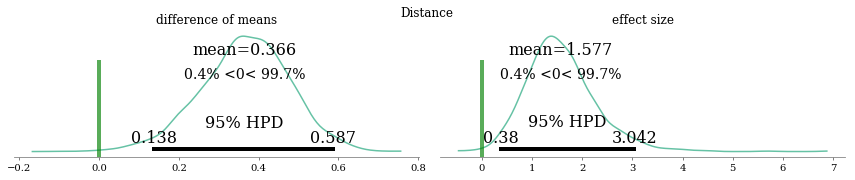

In [216]:
pm.plot_posterior(trace_dist[1000:],
                  varnames=[r'difference of means', "effect size"],
                  ref_val=0,
                  kde_plot=True)
plt.gcf().suptitle("Distance")

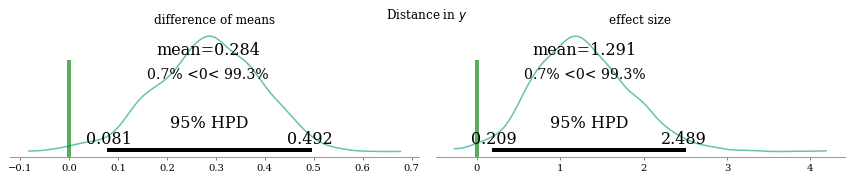

In [220]:
pm.plot_posterior(trace_rmsy[1000:],
                  varnames=[r'difference of means', "effect size"],
                  ref_val=0,
                  kde_plot=True)
plt.gcf().suptitle("Distance in $y$")

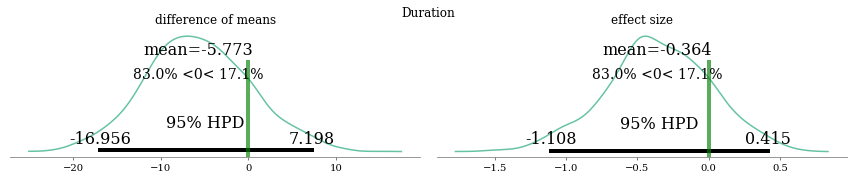

In [221]:
pm.plot_posterior(trace_dur[1000:],
                  varnames=[r'difference of means', "effect size"],
                  ref_val=0,
                  kde_plot=True)
plt.gcf().suptitle("Duration")

# t-Tests

## Duration

In [235]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard)].duration
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit)].duration
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=-0.8886795125557122, pvalue=0.38820459280857633)

In [234]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard) & (analyses.group==0)].duration
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit) & (analyses.group==0)].duration
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=-0.26990999980529884, pvalue=0.79501344477690417)

In [231]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard) & (analyses.group==1)].duration
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit) & (analyses.group==1)].duration
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=-0.95598318142183381, pvalue=0.37092235643331684)

## Distance

In [308]:
print(sample1.values)
print(sample2.values)

[ 2.20285109  1.77483437  0.79014686  0.80230698  0.88116913  0.68149374
  0.5633222   0.4355482   0.95629038  0.40711839  0.77310354  0.42190738
  0.92506742  0.37271373  0.95770257  0.37880511]
[ 0.25910881  0.10269426  0.32959885  0.36408079  0.87287544  0.28154889
  0.57765442  0.87033085  0.18724493  0.33199181  0.45023405  1.2588463
  0.26061967  0.28295843  0.24293427  0.8910934 ]


In [306]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard)].dist_err
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit)].dist_err
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=1.9871730494870421, pvalue=0.065480421384341986)

In [237]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard) & (analyses.group==0)].dist_err
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit) & (analyses.group==0)].dist_err
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=2.6876634513523934, pvalue=0.031191096487506537)

In [238]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard) & (analyses.group==1)].dist_err
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit) & (analyses.group==1)].dist_err
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=0.087693685916465369, pvalue=0.93257610546421488)

## X-distance

In [245]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard)].x_err
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit)].x_err
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=0.37475254925133394, pvalue=0.71308982737701965)

In [246]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard) & (analyses.group==0)].x_err
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit) & (analyses.group==0)].x_err
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=1.0823383787035141, pvalue=0.31497117789525086)

In [247]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard) & (analyses.group==1)].x_err
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit) & (analyses.group==1)].x_err
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=-0.92018296792624077, pvalue=0.38808786865899048)

## X-error

In [242]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard)].rms_x
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit)].rms_x
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=1.3881015975421782, pvalue=0.18537921030343171)

In [243]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard) & (analyses.group==0)].rms_x
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit) & (analyses.group==0)].rms_x
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=2.178862733046409, pvalue=0.065751017652833421)

In [244]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard) & (analyses.group==1)].rms_x
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit) & (analyses.group==1)].rms_x
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=-0.88503695752902811, pvalue=0.40550994650102107)

## Y-distance

In [248]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard)].y_err
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit)].y_err
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=-2.6931108665292247, pvalue=0.016687673522162716)

In [249]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard) & (analyses.group==0)].y_err
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit) & (analyses.group==0)].y_err
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=-5.2624770555050775, pvalue=0.0011701775978333712)

In [250]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard) & (analyses.group==1)].y_err
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit) & (analyses.group==1)].y_err
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=-0.44837591485948136, pvalue=0.66743167859471408)

## Y-error

In [239]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard)].rms_y
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit)].rms_y
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=1.8217326248450141, pvalue=0.088495393987259335)

In [240]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard) & (analyses.group==0)].rms_y
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit) & (analyses.group==0)].rms_y
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=2.1568292032546359, pvalue=0.067925209673336567)

In [241]:
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard) & (analyses.group==1)].rms_y
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit) & (analyses.group==1)].rms_y
stats.ttest_rel(sample1, sample2)

Ttest_relResult(statistic=0.34749337176320527, pvalue=0.73843469572198872)

# Statistical Analysis

In [190]:
def dnorm(x, mu, sd):
    return 1/(sd * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sd**2))

def dexp(x, l):
    return l * np.exp(- l*x)

def likelihood(parameters):
    mu1, sd1, mu2, sd2 = parameters
    return dnorm(sample1, mu1, sd1).prod()*dnorm(sample2, mu2, sd2).prod()

def prior(pooled, parameters):
    mu1, sd1, mu2, sd2 = parameters
    return (dnorm(mu1, pooled.mean(), 1000*pooled.std())
            * dnorm(mu2, pooled.mean(), 1000*pooled.std())
            * dexp(sd1, 0.1) 
            * dexp(sd2, 0.1))

def posterior(pooled, parameters):
    return likelihood(parameters)*prior(pooled, parameters)

def mcmc(pooled, parameters, n_iter=10000):
    results = np.zeros([niter, 4])
    results[1,:] = parameters

    for iteration in np.arange(2, niter):
        candidate = parameters + np.random.normal(0, 0.5, 4)
        ratio = posterior(pooled, candidate) / posterior(pooled, parameters)
        if np.random.uniform() < ratio:
            parameters = candidate
        results[iteration, :] = parameters

    #burn-in
    results = results[499:niter-1, :]
    
    return results
    
def best(sample1, sample2, params=None, n_iter=10000):
    if params is None:
        params = np.array([100, 10, 100, 10])
    pooled = np.append(sample1, sample2)
    results = mcmc(pooled, params, n_iter=n_iter)
    mu1 = results[:, 1]
    mu2 = results[:, 3]
    return mu2 - mu1

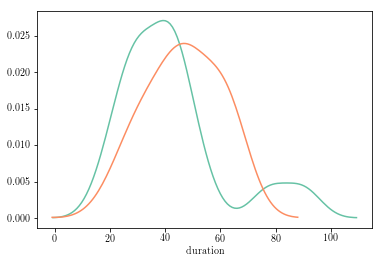

In [191]:
sample1 = analyses[analyses.experiment_type==ExperimentType.Onboard].duration
sample2 = analyses[analyses.experiment_type==ExperimentType.Spirit].duration
sns.distplot(sample1, hist=False)
sns.distplot(sample2, hist=False)

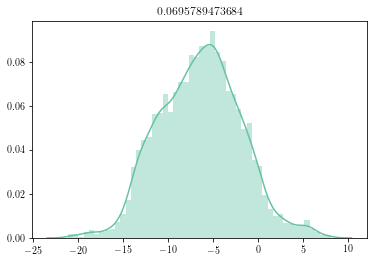

In [163]:
d = best(sample1, sample2, n_iter=1000)
sns.distplot(d)
plt.title(np.mean(d > 0))

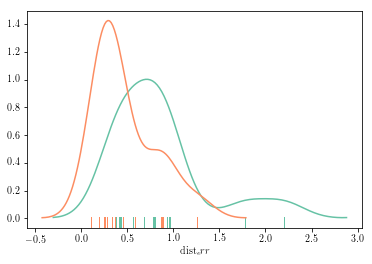

In [178]:
sample1 = analyses[analyses.experiment_type==ExperimentType.Onboard].dist_err
sample2 = analyses[analyses.experiment_type==ExperimentType.Spirit].dist_err
sns.distplot(sample1, hist=False, rug=True)
sns.distplot(sample2, hist=False, rug=True)

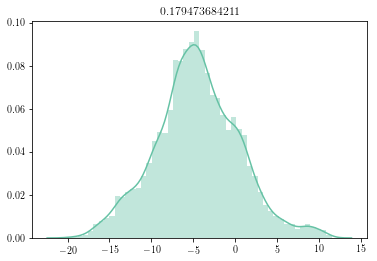

In [192]:
d = best(sample1, sample2, n_iter=10000)
sns.distplot(d)
plt.title(np.mean(d > 0))

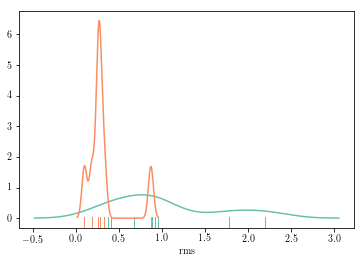

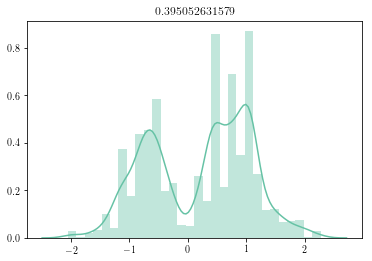

In [217]:
def dnorm(x, mu, sig):
    return 1/(sig * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sig**2))

def dexp(x, l):
    return l * np.exp(- l*x)

def like(parameters):
    [mu1, sig1, mu2, sig2] = parameters
    return dnorm(sample1, mu1, sig1).prod()*dnorm(sample2, mu2, sig2).prod()

def prior(parameters):
    [mu1, sig1, mu2, sig2] = parameters
    return dnorm(mu1, pooled.mean(), 1000*pooled.std()) * dnorm(mu2, pooled.mean(), 1000*pooled.std()) * dexp(sig1, 0.1) * dexp(sig2, 0.1)

def posterior(parameters):
    [mu1, sig1, mu2, sig2] = parameters
    return like([mu1, sig1, mu2, sig2])*prior([mu1, sig1, mu2, sig2])


#create samples
np.random.seed=7
#sample1 = np.random.normal(100, 3, 8)
#sample2 = np.random.normal(97, 3, 10)
sample1 = analyses[(analyses.experiment_type==ExperimentType.Onboard) & (analyses.group==0)].rms
sample2 = analyses[(analyses.experiment_type==ExperimentType.Spirit) & (analyses.group==0)].rms

pooled= np.append(sample1, sample2)

sns.distplot(sample1, hist=False, rug=True)
sns.distplot(sample2, hist=False, rug=True)

mu1 = 1
sig1 = 0.1
mu2 = 1
sig2 = 0.1
parameters = np.array([mu1, sig1, mu2, sig2])

niter = 10000

results = np.zeros([niter, 4])
results[1,:] = parameters

for iteration in np.arange(2,niter):
    candidate = parameters + np.random.normal(0,0.5,4)
    ratio = posterior(candidate)/posterior(parameters)
    if np.random.uniform() < ratio:
        parameters = candidate
    results[iteration,:] = parameters

#burn-in
results = results[499:niter-1,:]

mu1 = results[:,1]
mu2 = results[:,3]

d = (mu1 - mu2)
p_value = np.mean(mu1 < mu2)

plt.figure()
sns.distplot(d)
plt.title(p_value)